In [1]:
#### Imports para entrenamiento, predicción y evaluación del modelo ####
#### NO QUITAR ####
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
#### Código Agregado ####
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from wordcloud import WordCloud
%matplotlib inline
sns.set_style('darkgrid')

In [2]:
### Loading Data
data_file_path = '/home/mgarcia/Documents/Study/DiploDatos/Exercises/Integrators/Integrator_1/data.csv'
tag_file_path = '/home/mgarcia/Documents/Study/DiploDatos/Exercises/Integrators/Integrator_1/tag.csv'
data = pd.read_csv(data_file_path)
tag = pd.read_csv(tag_file_path)

In [3]:
pd.set_option('display.max_columns',30)

In [4]:
data.head(5)

,SUSCRIBER_KEY,FECHA_CORTE,LAT_PROV_BTS,LON_PROV_BTS,LAT_CITY_BTS,LON_CITY_BTS,VALUE_SEGMENT,SEGMENTATION,MICROSEGMENTATION,SOURCE,DEVICE_MODEL_NAME,DEVICE_VENDOR_NAME,NETWORK_TECH,COMMERCIAL_ACTIVATION_DATE,TENURE_CUSTOMER,...,PACK_SMS_AMT_W10,PACK_SMS_AMT_W11,PACK_SMS_AMT_W12,PACK_DATA_EXP_W1,PACK_DATA_EXP_W2,PACK_DATA_EXP_W3,PACK_DATA_EXP_W4,PACK_DATA_EXP_W5,PACK_DATA_EXP_W6,PACK_DATA_EXP_W7,PACK_DATA_EXP_W8,PACK_DATA_EXP_W9,PACK_DATA_EXP_W10,PACK_DATA_EXP_W11,PACK_DATA_EXP_W12
0,E_63734494_20190215,08-SEP-19,8.5848,-82.3885,-82.43330,8.43330,3 - SILVER,2-PD,PD1,NEW,G4 STYLUS (H540),LG,LTE,15-FEB-19,8,...,0.0,0.0,0.0,0,0,5,6,10,11,0,4,11,0,0,0
1,E_66977552_20190518,08-SEP-19,8.5848,-82.3885,-82.43330,8.43330,4 - BRONZE,7-LOW,LOW3,NEW,NOT_IDENTIFIED,NOT_IDENTIFIED,NaN,18-MAY-19,5,...,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0
2,E_69159695_20180116,08-SEP-19,8.1231,-81.0755,-78.16140,8.65525,3 - SILVER,6-OH,LOW4,NEW,NOT_IDENTIFIED,NOT_IDENTIFIED,3G,16-JAN-18,21,...,0.0,0.0,0.0,7,6,13,10,4,11,0,0,0,0,9,0
3,E_65255730_20190416,08-SEP-19,9.0832,-79.5924,-79.51973,8.99360,3 - SILVER,7-LOW,LOW3,NEW,JENNY TV 2.8,BLU,LTE,16-APR-19,6,...,0.0,0.0,0.0,0,0,6,0,0,0,0,0,0,0,0,0
4,E_67893872_20161201,08-SEP-19,9.0832,-79.5924,-79.51973,8.99360,3 - SILVER,3-DO,DO3,NEW,GALAXY J1 (SM-J111MDS),SAMSUNG,LTE,01-DEC-16,35,...,0.0,0.0,0.0,0,4,11,18,7,14,13,20,27,34,7,14


## Limpiando el target

 Sacamos las columnas que no nos van a hacer falta, ya que queremos predecir si cargará o no

In [5]:
tag.drop(columns=[x for x in tag.columns if 'AMT' in x],inplace=True)

Sumaremos todas las cargas que realizaron

In [6]:
tag['Total'] = tag[tag.columns[1:]].sum(axis=1)

In [7]:
tag.drop(columns=[x for x in tag.columns if 'EVT' in x],inplace=True)

Reemplazamos la cantidad de cargar por "False" si cargó, y "True" si no cargó 

In [8]:
tag['Total']= tag['Total']==0

In [9]:
tag.rename(columns={'Total':'Target'},inplace=True)

In [10]:
tag['Target'] = tag['Target'].astype(int)

 Unimos los datasets

In [11]:
fulldata = data.merge(tag, on='SUSCRIBER_KEY')

In [12]:
del tag
del data

 # Limpieza de columnas 

Todas las que dicen en el documento 'No se usa'

In [13]:
fulldata.drop(columns=[x for x in fulldata.columns if 'ARPU' in x],inplace=True)

Quedaron 5 a eliminar (quedaban 190 después de que el profe eliminó las innecesarias)

In [14]:
que_quedaron= ["USE_LCL_VOI_AMT_M1", "USE_LCL_VOI_AMT_M2","USE_LCL_VOI_AMT_M3",]

In [15]:
fulldata.drop(columns=que_quedaron,inplace=True)

In [16]:
fulldata.shape

(319222, 192)

Removemos columnas que tienen un solo valor 

In [17]:
columnas_a_eliminar = [x for x in fulldata.columns if fulldata[x].nunique()==1]

In [18]:
fulldata.drop(columns=columnas_a_eliminar, inplace=True)

In [19]:
fulldata.shape

(319222, 190)

## Veamos ahora los nulos

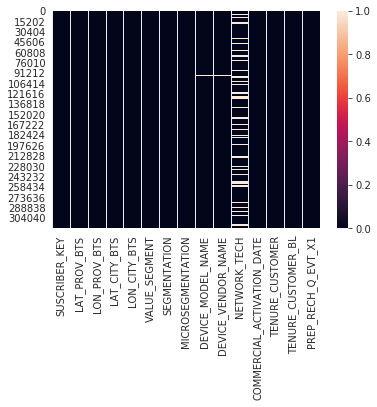

In [20]:
sns.heatmap(fulldata[fulldata.columns[0:15]].isnull())

In [21]:
nullcount = {col:fulldata[col].isnull().sum() for col in fulldata.columns}

Hasta ahí los nulos eran una lista. Ahora con pandas los convertimos en un array

In [22]:
missing = pd.Series(nullcount)

In [23]:
missing

SUSCRIBER_KEY          0
LAT_PROV_BTS         734
LON_PROV_BTS         734
LAT_CITY_BTS         734
LON_CITY_BTS         734
                    ... 
PACK_DATA_EXP_W9       0
PACK_DATA_EXP_W10      0
PACK_DATA_EXP_W11      0
PACK_DATA_EXP_W12      0
Target                 0
Length: 190, dtype: int64

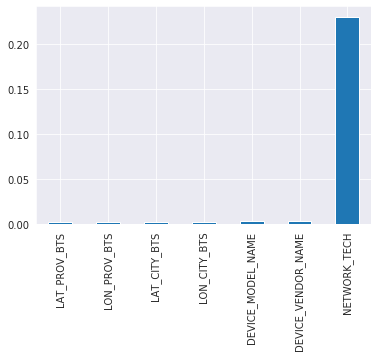

In [24]:
missing[missing>0].div(fulldata.shape[0]).plot.bar()

---

# Limpieza de datos categóricos

---

Analizamos los datos categoricos

In [25]:
fulldata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 319222 entries, 0 to 319221
Columns: 190 entries, SUSCRIBER_KEY to Target
dtypes: float64(82), int64(98), object(10)
memory usage: 465.2+ MB


In [26]:
cols = fulldata.columns 
num_cols = fulldata._get_numeric_data().columns 
cat_columns = list(set(cols) - set(num_cols))

In [27]:
cat_columns

['VALUE_SEGMENT',
 'MICROSEGMENTATION',
 'COMMERCIAL_ACTIVATION_DATE',
 'DEVICE_VENDOR_NAME',
 'PREP_RECH_LAST_DAY_12W',
 'PREP_RECH_CHNNL_MODE12W',
 'DEVICE_MODEL_NAME',
 'NETWORK_TECH',
 'SEGMENTATION',
 'SUSCRIBER_KEY']

In [28]:
Cat_fulldata =  fulldata[cat_columns].copy()

In [29]:
Cat_fulldata.head(5)

,VALUE_SEGMENT,MICROSEGMENTATION,COMMERCIAL_ACTIVATION_DATE,DEVICE_VENDOR_NAME,PREP_RECH_LAST_DAY_12W,PREP_RECH_CHNNL_MODE12W,DEVICE_MODEL_NAME,NETWORK_TECH,SEGMENTATION,SUSCRIBER_KEY
0,3 - SILVER,PD1,15-FEB-19,LG,19-AUG-19,"N/A,3;UGW,9",G4 STYLUS (H540),LTE,2-PD,E_63734494_20190215
1,4 - BRONZE,LOW3,18-MAY-19,NOT_IDENTIFIED,03-JUL-19,"UGW,1",NOT_IDENTIFIED,NaN,7-LOW,E_66977552_20190518
2,3 - SILVER,LOW4,16-JAN-18,NOT_IDENTIFIED,02-SEP-19,"N/A,3;UGW,4",NOT_IDENTIFIED,3G,6-OH,E_69159695_20180116
3,3 - SILVER,LOW3,16-APR-19,BLU,01-SEP-19,"UGW,2",JENNY TV 2.8,LTE,7-LOW,E_65255730_20190416
4,3 - SILVER,DO3,01-DEC-16,SAMSUNG,05-SEP-19,"N/A,1;UGW,4",GALAXY J1 (SM-J111MDS),LTE,3-DO,E_67893872_20161201


Logramos identificar que las columas network tech, device vendor model y device vendor name tienen valores nulos ya sea como 'NaN' o como 'NOT_IDENTIFIED'. Por eso decidimos imputarlos..

## Imputar network tech

In [30]:
fulldata['NETWORK_TECH'].value_counts(normalize=True,dropna=False)

LTE    0.467399
3G     0.272118
NaN    0.229959
2G     0.030524
Name: NETWORK_TECH, dtype: float64

Vemos que dentro de los valores tenemos un 22% que son NaN

In [31]:
fulldata['NETWORK_TECH'].value_counts(dropna=False)

LTE    149204
3G      86866
NaN     73408
2G       9744
Name: NETWORK_TECH, dtype: int64

Calculamos la moda de la columna NETWORK_TECH para luego reemplazarla por los valores NaN

In [32]:
moda_network_tech=fulldata['NETWORK_TECH'].mode()
moda_network_tech[0]

'LTE'

In [33]:
fulldata['NETWORK_TECH'].fillna(moda_network_tech[0], inplace=True)

In [34]:
fulldata['NETWORK_TECH'].value_counts(normalize=True,dropna=False)

LTE    0.697358
3G     0.272118
2G     0.030524
Name: NETWORK_TECH, dtype: float64

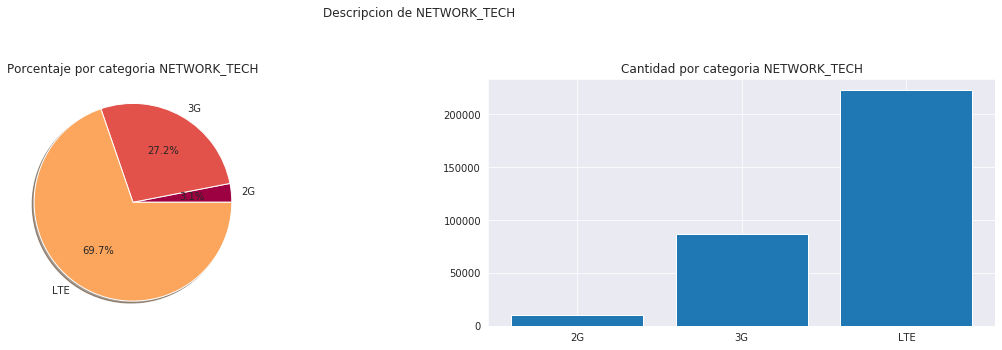

In [35]:
pie_labels=fulldata['NETWORK_TECH'].sort_values().unique()
pie_data_cantidad=fulldata['NETWORK_TECH'].value_counts(dropna=False).sort_values()
pie_data_porcentaje=fulldata['NETWORK_TECH'].value_counts(normalize=True,dropna=False).sort_values()
#explode= (0,0.1,0)
plt.figure(1,figsize=(20,10))
the_grid=GridSpec(2,2)
cmap = plt.get_cmap('Spectral')
colors=[cmap(i) for i in np.linspace(0,1,8)]
#Grafico de cantidades de NETWORK_TECH
plt.subplot(the_grid[0,1], title='Cantidad por categoria NETWORK_TECH')
cantidades_pie=plt.bar(pie_labels ,pie_data_cantidad)
#Grafico de porcentajes de NETWORK_TECH
plt.subplot(the_grid[0,0], title='Porcentaje por categoria NETWORK_TECH')
porcentaje_pie=plt.pie(pie_data_porcentaje, labels=pie_labels, autopct='%1.1f%%', shadow=True, colors=colors)

plt.suptitle('Descripcion de NETWORK_TECH')

plt.show()

Vemos que el 22% de NaN paso a LTE 

## Imputar device model name

In [36]:
fulldata['DEVICE_MODEL_NAME'].value_counts(normalize=True,dropna=False)

NOT_IDENTIFIED                           0.134881
GALAXY GRAND PRIME DUOS (SM-G532M DS)    0.105281
GALAXY GRAND NEO (GT-I9060C)             0.029039
GALAXY J7 DUOS LTE (SM-J700MDS)          0.023892
Y5 2018 (DRA-LX3)                        0.020807
                                           ...   
CPH1819                                  0.000003
DUO 212                                  0.000003
KP210A                                   0.000003
6590I                                    0.000003
ARMOR X                                  0.000003
Name: DEVICE_MODEL_NAME, Length: 2477, dtype: float64

Vemos que el 13% de los datos de la columna DEVICE_MODEL_NAME son 'NOT_IDENTIFIED', con lo cual procedemos a inputar los datos por el valor de la moda.

In [37]:
device_model_name=fulldata[fulldata['DEVICE_MODEL_NAME']!='NOT_IDENTIFIED']
moda_device_model_name=device_model_name.DEVICE_MODEL_NAME.mode()
moda_device_model_name[0]

'GALAXY GRAND PRIME DUOS (SM-G532M DS)'

In [38]:
fulldata['DEVICE_MODEL_NAME'].replace({'NOT_IDENTIFIED':moda_device_model_name[0]},inplace=True)

In [39]:
fulldata['DEVICE_MODEL_NAME'].fillna(moda_device_model_name[0], inplace=True)

In [40]:
fulldata['DEVICE_MODEL_NAME'].value_counts(normalize=True,dropna=False)

GALAXY GRAND PRIME DUOS (SM-G532M DS)    0.242916
GALAXY GRAND NEO (GT-I9060C)             0.029039
GALAXY J7 DUOS LTE (SM-J700MDS)          0.023892
Y5 2018 (DRA-LX3)                        0.020807
GALAXY J2 PRIME (SM-G532M)               0.020259
                                           ...   
SGH-E256                                 0.000003
GALAXY S5 LTE (SM-G900FD)                0.000003
2600                                     0.000003
GT-I8000                                 0.000003
GR500                                    0.000003
Name: DEVICE_MODEL_NAME, Length: 2475, dtype: float64

Vemos que los valores de 'NOT_IDENTIFIED' se reemplazaron por la moda.

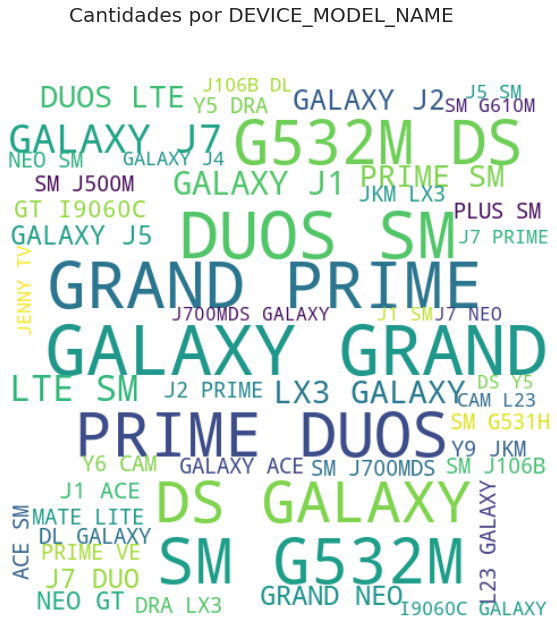

In [41]:
text=' '.join(fulldata['DEVICE_MODEL_NAME'])
# Create the wordcloud object
wordcloud = WordCloud(width=480, height=480, margin=0, background_color="white",max_words=50).generate(text)

plt.figure(1,figsize=(20,10))
the_grid=GridSpec(1,1)
plt.subplot(the_grid[0,0])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.suptitle('Cantidades por DEVICE_MODEL_NAME', fontsize=20)
plt.show()


## Imputar device vendor name

In [42]:
fulldata['DEVICE_VENDOR_NAME'].value_counts(normalize=True,dropna=False)

SAMSUNG           0.502356
HUAWEI            0.173418
NOT_IDENTIFIED    0.134881
LG                0.051610
BLU               0.030712
                    ...   
IMO               0.000003
MASTER            0.000003
SEIKO             0.000003
INTKI             0.000003
HOLLEY            0.000003
Name: DEVICE_VENDOR_NAME, Length: 234, dtype: float64

Vemos que el 13% de los datos de la columna DEVICE_V.ENDOR_NAME son 'NOT_IDENTIFIED', por lo que procedemos a reemplazar los valores por la moda 

In [43]:
device_vendor_name=fulldata[fulldata['DEVICE_VENDOR_NAME']!='NOT_IDENTIFIED']
moda_device_vendor_name=device_vendor_name.DEVICE_VENDOR_NAME.mode()
moda_device_vendor_name[0]

'SAMSUNG'

In [44]:
fulldata['DEVICE_VENDOR_NAME'].replace({'NOT_IDENTIFIED':moda_device_vendor_name[0]},inplace=True)
fulldata['DEVICE_VENDOR_NAME'].fillna(moda_device_vendor_name[0], inplace=True)
fulldata['DEVICE_VENDOR_NAME'].value_counts(normalize=True,dropna=False)

SAMSUNG       0.639990
HUAWEI        0.173418
LG            0.051610
BLU           0.030712
NOKIA         0.026953
                ...   
SONIM         0.000003
CHANGJIANG    0.000003
TAXCEL        0.000003
INFINIX       0.000003
ALFATEL       0.000003
Name: DEVICE_VENDOR_NAME, Length: 232, dtype: float64

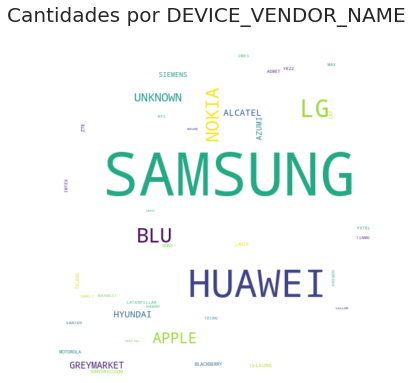

In [45]:
text=' '.join(fulldata['DEVICE_VENDOR_NAME'])
# Create the wordcloud object
wordcloud = WordCloud(width=480, height=480, margin=0, background_color="white",max_words=40).generate(text)
plt.figure(figsize=(6,6))
the_grid=GridSpec(1,1)
plt.subplot(the_grid[0,0])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.suptitle('Cantidades por DEVICE_VENDOR_NAME', fontsize=20)
plt.show()


Los valores de NOT_IDENTIFIED fueron reemplazados por su moda, que en este caso es 'SAMSUNG'.

---

# Limpieza de datos numéricos

---

Ahora procedemos a limpiar los datos numericos, para esto separamos el data set en datos referidos a las recargas, pack y a trafico de datos.

## Limpieza de datos de Pack

Primero separamos las columnas que son de datos referidos a los packs

In [46]:
Pack_columns=['SUSCRIBER_KEY']
for a in cols:
    if a.startswith('PACK_'):
        Pack_columns.append(a)

In [47]:
Pack_fulldata=fulldata[Pack_columns]
Pack_fulldata

,SUSCRIBER_KEY,PACK_DATA_Q_X1,PACK_DATA_Q_X2,PACK_DATA_Q_X3,PACK_DATA_AMT_X1,PACK_DATA_AMT_X2,PACK_DATA_AMT_X3,PACK_VOICE_Q_X1,PACK_VOICE_Q_X2,PACK_VOICE_Q_X3,PACK_VOICE_AMT_X1,PACK_VOICE_AMT_X2,PACK_VOICE_AMT_X3,PACK_SMS_Q_X1,PACK_SMS_Q_X2,...,PACK_SMS_AMT_W10,PACK_SMS_AMT_W11,PACK_SMS_AMT_W12,PACK_DATA_EXP_W1,PACK_DATA_EXP_W2,PACK_DATA_EXP_W3,PACK_DATA_EXP_W4,PACK_DATA_EXP_W5,PACK_DATA_EXP_W6,PACK_DATA_EXP_W7,PACK_DATA_EXP_W8,PACK_DATA_EXP_W9,PACK_DATA_EXP_W10,PACK_DATA_EXP_W11,PACK_DATA_EXP_W12
0,E_63734494_20190215,4,5,4,6.00,9.0,6.00,0,0,0,0.00,0.00,0.00,0,0,...,0.0,0.0,0.0,0,0,5,6,10,11,0,4,11,0,0,0
1,E_66977552_20190518,0,0,0,0.00,0.0,0.00,0,0,0,0.00,0.00,0.00,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0
2,E_69159695_20180116,5,3,3,4.50,3.0,1.50,0,0,0,0.00,0.00,0.00,0,0,...,0.0,0.0,0.0,7,6,13,10,4,11,0,0,0,0,9,0
3,E_65255730_20190416,3,0,0,0.99,0.0,0.00,0,0,0,0.00,0.00,0.00,0,0,...,0.0,0.0,0.0,0,0,6,0,0,0,0,0,0,0,0,0
4,E_67893872_20161201,3,4,3,8.99,9.0,10.00,0,0,0,0.00,0.00,0.00,0,0,...,0.0,0.0,0.0,0,4,11,18,7,14,13,20,27,34,7,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319217,E_66690182_20190121,0,0,4,0.00,0.0,4.99,0,0,0,0.00,0.00,0.00,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,3,10,0
319218,E_65347728_20171017,3,5,7,3.00,6.0,10.48,4,4,7,3.98,3.98,9.95,0,0,...,0.0,0.0,0.0,0,0,0,8,9,0,4,11,10,7,13,7
319219,E_68063707_20150701,0,0,0,0.00,0.0,0.00,0,3,0,0.00,1.99,0.00,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0
319220,E_67206080_20181010,0,0,3,0.00,0.0,5.00,0,0,0,0.00,0.00,0.00,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,5,12


Comparamos las columnas de pack semanal contra las mensuales para buscar datos incorrectos o verificar si la informacion es duplicada.

### Para la cantidad de pack de datos :

In [48]:
Pack_fulldata[['PACK_DATA_Q_W1','PACK_DATA_Q_W2','PACK_DATA_Q_W3','PACK_DATA_Q_W4','PACK_DATA_Q_X1','PACK_DATA_Q_W5','PACK_DATA_Q_W6','PACK_DATA_Q_W7','PACK_DATA_Q_W8','PACK_DATA_Q_X2','PACK_DATA_Q_W9','PACK_DATA_Q_W10','PACK_DATA_Q_W11','PACK_DATA_Q_W12','PACK_DATA_Q_X3']]

,PACK_DATA_Q_W1,PACK_DATA_Q_W2,PACK_DATA_Q_W3,PACK_DATA_Q_W4,PACK_DATA_Q_X1,PACK_DATA_Q_W5,PACK_DATA_Q_W6,PACK_DATA_Q_W7,PACK_DATA_Q_W8,PACK_DATA_Q_X2,PACK_DATA_Q_W9,PACK_DATA_Q_W10,PACK_DATA_Q_W11,PACK_DATA_Q_W12,PACK_DATA_Q_X3
0,0,0,3,3,4,3,4,0,0,5,4,0,0,0,4
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,0,3,3,5,0,3,0,0,3,0,0,3,0,3
3,0,0,3,0,3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,3,3,0,3,0,3,4,0,3,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319217,0,0,0,0,0,0,0,0,0,0,0,0,4,0,4
319218,0,0,0,3,3,3,0,0,4,5,3,3,4,3,7
319219,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
319220,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3


Vemos que hay inconsistencias entre las cantidades semanales y las mensuales, por ende la informacion es incorrecta.
Eliminamos las columnas con la premisa de no meter basura en el modelo.

In [49]:
fulldata.drop(columns=[x for x in fulldata.columns if 'PACK_DATA_Q' in x],inplace=True)

### Para los montos de pack de datos:

In [50]:
Pack_fulldata[['PACK_DATA_AMT_W1','PACK_DATA_AMT_W2','PACK_DATA_AMT_W3','PACK_DATA_AMT_W4','PACK_DATA_AMT_X1','PACK_DATA_AMT_W5','PACK_DATA_AMT_W6','PACK_DATA_AMT_W7','PACK_DATA_AMT_W8','PACK_DATA_AMT_X2','PACK_DATA_AMT_W9','PACK_DATA_AMT_W10','PACK_DATA_AMT_W11','PACK_DATA_AMT_W12','PACK_DATA_AMT_X3']]


,PACK_DATA_AMT_W1,PACK_DATA_AMT_W2,PACK_DATA_AMT_W3,PACK_DATA_AMT_W4,PACK_DATA_AMT_X1,PACK_DATA_AMT_W5,PACK_DATA_AMT_W6,PACK_DATA_AMT_W7,PACK_DATA_AMT_W8,PACK_DATA_AMT_X2,PACK_DATA_AMT_W9,PACK_DATA_AMT_W10,PACK_DATA_AMT_W11,PACK_DATA_AMT_W12,PACK_DATA_AMT_X3
0,0.0,0.0,3.00,3.00,6.00,3.0,6.0,0.0,0.0,9.0,6.0,0.0,0.00,0.00,6.00
1,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00
2,1.5,0.0,1.50,1.50,4.50,0.0,3.0,0.0,0.0,3.0,0.0,0.0,1.50,0.00,1.50
3,0.0,0.0,0.99,0.00,0.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00
4,0.0,0.0,0.00,8.99,8.99,0.0,5.0,0.0,4.0,9.0,0.0,10.0,0.00,0.00,10.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319217,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.99,0.00,4.99
319218,0.0,0.0,0.00,3.00,3.00,1.5,0.0,0.0,4.5,6.0,1.5,1.5,4.50,2.98,10.48
319219,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00
319220,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,5.00,5.00


En este caso vemos que las columnas de montos mensuales coinciden con los montos semanales, por ende tener las 3 columnas mensuales seria tener datos repetidos ya que esto lo podemos ver haciendo la suma de los montos semanales.
Eliminamos entonces las columnas de los montos acumulados mensuales para pack de datos.

In [51]:
fulldata.drop(columns=[x for x in fulldata.columns if 'PACK_DATA_AMT_X' in x],inplace=True)

Text(0.5, 1.0, 'Monto de pack de datos (Semana 9 a 12)')

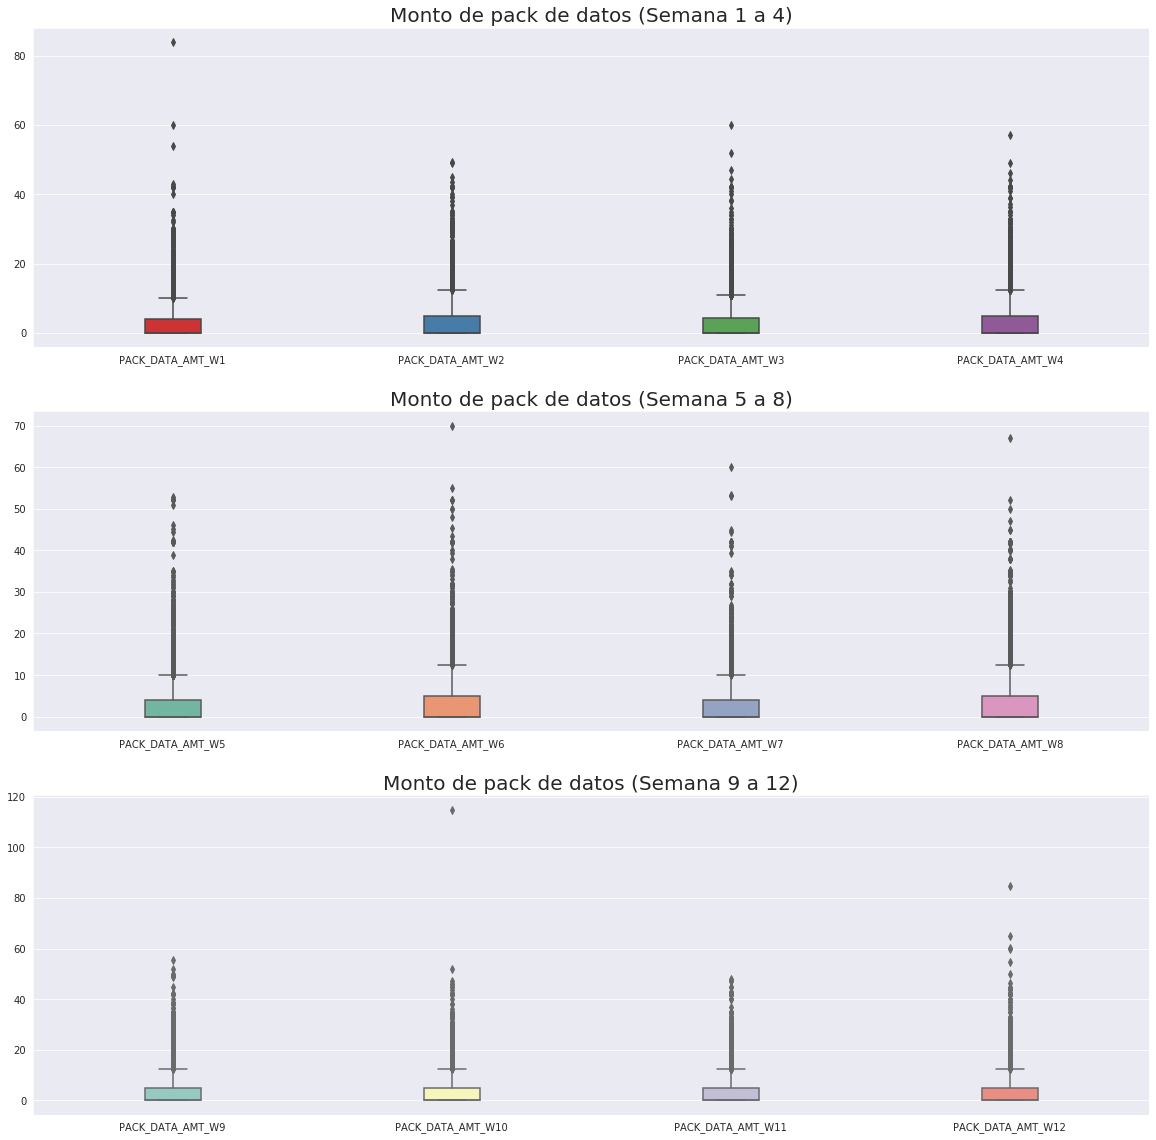

In [52]:
plt.figure(figsize=(20,20))

the_grid=GridSpec(3,1)
plt.subplot(the_grid[0,0])
data_to_box_plot1=Pack_fulldata[['PACK_DATA_AMT_W1','PACK_DATA_AMT_W2','PACK_DATA_AMT_W3','PACK_DATA_AMT_W4']]
a=sns.boxplot(data=data_to_box_plot1,orient="v", palette="Set1" ,width=0.2)
plt.subplot(the_grid[1,0])
data_to_box_plot2=Pack_fulldata[['PACK_DATA_AMT_W5','PACK_DATA_AMT_W6','PACK_DATA_AMT_W7','PACK_DATA_AMT_W8']]
b=sns.boxplot(data=data_to_box_plot2,orient="v", palette="Set2" ,width=0.2)
plt.subplot(the_grid[2,0])
data_to_box_plot3=Pack_fulldata[['PACK_DATA_AMT_W9','PACK_DATA_AMT_W10','PACK_DATA_AMT_W11','PACK_DATA_AMT_W12']]
c=sns.boxplot(data=data_to_box_plot3,orient="v", palette="Set3" ,width=0.2)

a.axes.set_title("Monto de pack de datos (Semana 1 a 4)",fontsize=20)
b.axes.set_title("Monto de pack de datos (Semana 5 a 8)",fontsize=20)
c.axes.set_title("Monto de pack de datos (Semana 9 a 12)",fontsize=20)

Vemos que tenemos outliers por lo que procedemos a la eliminacion de los mismos segun esten en el primer o tercer quartil y multiplicando por 1.5 

In [53]:
for column in fulldata[['PACK_DATA_AMT_W1','PACK_DATA_AMT_W2','PACK_DATA_AMT_W3','PACK_DATA_AMT_W4','PACK_DATA_AMT_W5','PACK_DATA_AMT_W6','PACK_DATA_AMT_W7','PACK_DATA_AMT_W8','PACK_DATA_AMT_W9','PACK_DATA_AMT_W10','PACK_DATA_AMT_W11','PACK_DATA_AMT_W12']]:
    Q1 = fulldata[column].quantile(0.25)
    Q3 = fulldata[column].quantile(0.75)
    IQR = Q3 - Q1
    fulldata[column] = np.where((fulldata[column] < (Q1 - 1.5 * IQR)) | (fulldata[column] > (Q3 + 1.5 * IQR)), fulldata[column].median(), fulldata[column])


Text(0.5, 1.0, 'Monto de pack de datos (Semana 9 a 12)')

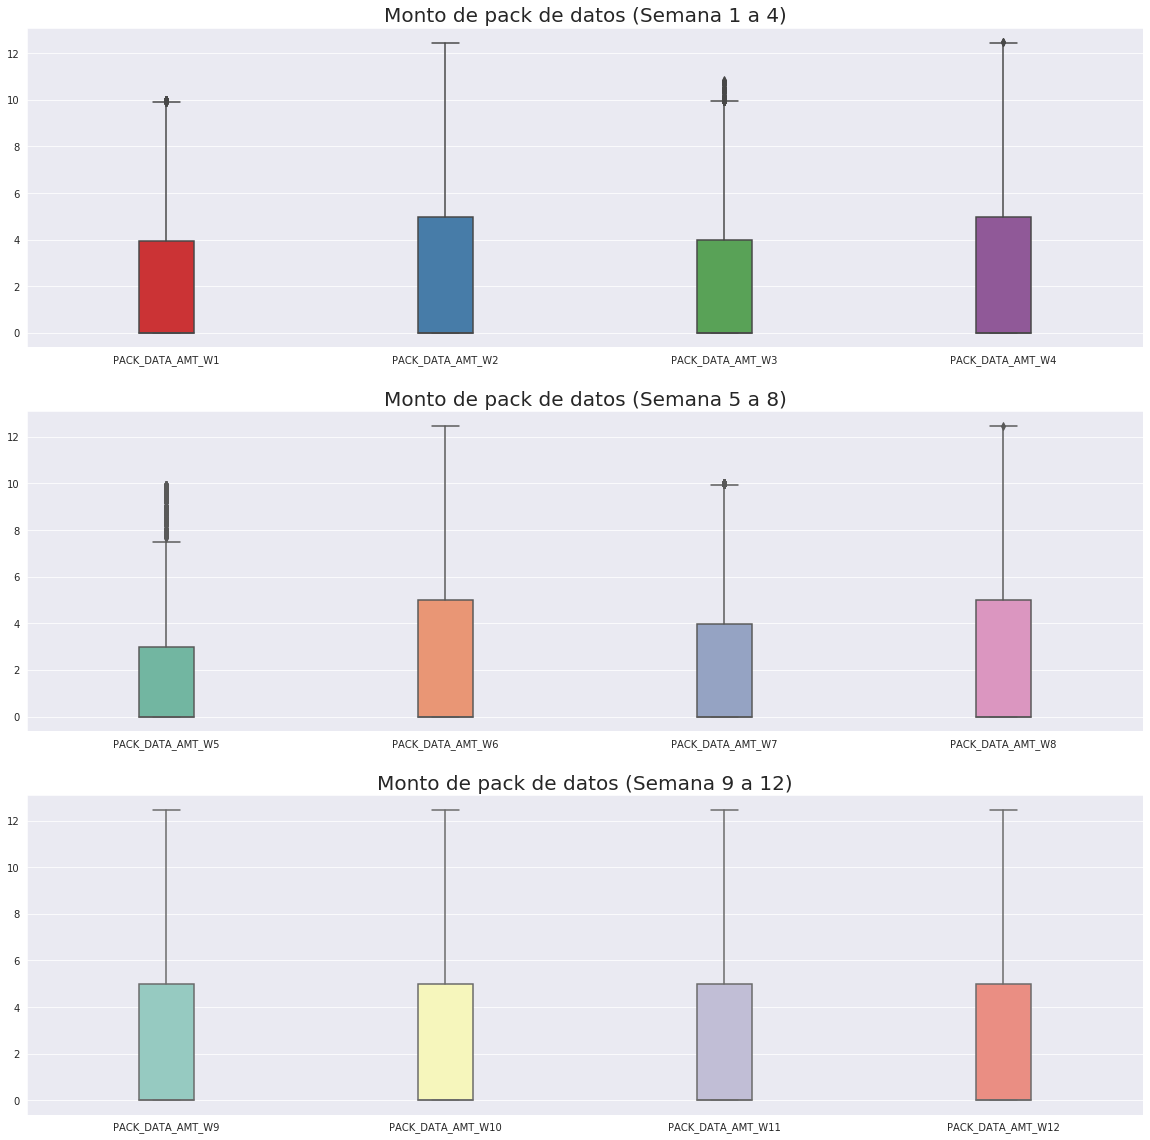

In [54]:
plt.figure(figsize=(20,20))

the_grid=GridSpec(3,1)
plt.subplot(the_grid[0,0])
data_to_box_plot1=fulldata[['PACK_DATA_AMT_W1','PACK_DATA_AMT_W2','PACK_DATA_AMT_W3','PACK_DATA_AMT_W4']]
a=sns.boxplot(data=data_to_box_plot1,orient="v", palette="Set1" ,width=0.2)
plt.subplot(the_grid[1,0])
data_to_box_plot2=fulldata[['PACK_DATA_AMT_W5','PACK_DATA_AMT_W6','PACK_DATA_AMT_W7','PACK_DATA_AMT_W8']]
b=sns.boxplot(data=data_to_box_plot2,orient="v", palette="Set2" ,width=0.2)
plt.subplot(the_grid[2,0])
data_to_box_plot3=fulldata[['PACK_DATA_AMT_W9','PACK_DATA_AMT_W10','PACK_DATA_AMT_W11','PACK_DATA_AMT_W12']]
c=sns.boxplot(data=data_to_box_plot3,orient="v", palette="Set3" ,width=0.2)

a.axes.set_title("Monto de pack de datos (Semana 1 a 4)",fontsize=20)
b.axes.set_title("Monto de pack de datos (Semana 5 a 8)",fontsize=20)
c.axes.set_title("Monto de pack de datos (Semana 9 a 12)",fontsize=20)


### Para la cantidad de pack de sms:

In [55]:
Pack_fulldata[['PACK_SMS_Q_W1','PACK_SMS_Q_W2','PACK_SMS_Q_W3','PACK_SMS_Q_W4','PACK_SMS_Q_X1','PACK_SMS_Q_W5','PACK_SMS_Q_W6','PACK_SMS_Q_W7','PACK_SMS_Q_W8','PACK_SMS_Q_X2','PACK_SMS_Q_W9','PACK_SMS_Q_W10','PACK_SMS_Q_W11','PACK_SMS_Q_W12','PACK_SMS_Q_X3']]

,PACK_SMS_Q_W1,PACK_SMS_Q_W2,PACK_SMS_Q_W3,PACK_SMS_Q_W4,PACK_SMS_Q_X1,PACK_SMS_Q_W5,PACK_SMS_Q_W6,PACK_SMS_Q_W7,PACK_SMS_Q_W8,PACK_SMS_Q_X2,PACK_SMS_Q_W9,PACK_SMS_Q_W10,PACK_SMS_Q_W11,PACK_SMS_Q_W12,PACK_SMS_Q_X3
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319217,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
319218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
319219,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
319220,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Vemos que las columnas de los pack de sms semanales no coinciden con el correspondiente acumulado mensual, por lo que se considera dato incorrecto y se elimina del dataset.

In [56]:
fulldata.drop(columns=[x for x in fulldata.columns if 'PACK_SMS_Q' in x],inplace=True)

### Para los montos en sms:

In [57]:
Pack_fulldata[['PACK_SMS_AMT_W1','PACK_SMS_AMT_W2','PACK_SMS_AMT_W3','PACK_SMS_AMT_W4','PACK_SMS_AMT_X1','PACK_SMS_AMT_W5','PACK_SMS_AMT_W6','PACK_SMS_AMT_W7','PACK_SMS_AMT_W8','PACK_SMS_AMT_X2','PACK_SMS_AMT_W9','PACK_SMS_AMT_W10','PACK_SMS_AMT_W11','PACK_SMS_AMT_W12','PACK_SMS_AMT_X3']]

,PACK_SMS_AMT_W1,PACK_SMS_AMT_W2,PACK_SMS_AMT_W3,PACK_SMS_AMT_W4,PACK_SMS_AMT_X1,PACK_SMS_AMT_W5,PACK_SMS_AMT_W6,PACK_SMS_AMT_W7,PACK_SMS_AMT_W8,PACK_SMS_AMT_X2,PACK_SMS_AMT_W9,PACK_SMS_AMT_W10,PACK_SMS_AMT_W11,PACK_SMS_AMT_W12,PACK_SMS_AMT_X3
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319217,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
319218,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
319219,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
319220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


En este caso los montos si coinciden, por lo cual se eliminan las columnas de acumulados para no repetir informacion.

In [58]:
fulldata.drop(columns=[x for x in fulldata.columns if 'PACK_SMS_AMT_X' in x],inplace=True)

### Para la cantidad de pack de voz:

In [59]:
Pack_fulldata[['PACK_VOICE_Q_W1','PACK_VOICE_Q_W2','PACK_VOICE_Q_W3','PACK_VOICE_Q_W4','PACK_VOICE_Q_X1','PACK_VOICE_Q_W5','PACK_VOICE_Q_W6','PACK_VOICE_Q_W7','PACK_VOICE_Q_W8','PACK_VOICE_Q_X2','PACK_VOICE_Q_W9','PACK_VOICE_Q_W10','PACK_VOICE_Q_W11','PACK_VOICE_Q_W12','PACK_VOICE_Q_X3']]

,PACK_VOICE_Q_W1,PACK_VOICE_Q_W2,PACK_VOICE_Q_W3,PACK_VOICE_Q_W4,PACK_VOICE_Q_X1,PACK_VOICE_Q_W5,PACK_VOICE_Q_W6,PACK_VOICE_Q_W7,PACK_VOICE_Q_W8,PACK_VOICE_Q_X2,PACK_VOICE_Q_W9,PACK_VOICE_Q_W10,PACK_VOICE_Q_W11,PACK_VOICE_Q_W12,PACK_VOICE_Q_X3
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319217,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
319218,0,0,0,4,4,3,0,0,3,4,0,4,0,5,7
319219,0,0,0,0,0,0,3,0,0,3,0,0,0,0,0
319220,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Aca vemos que las cantidades semanales no se corresponden con los acumulados mensuales, lo tomamos como valores incorrectos y procedemos a borrarlos

In [60]:
fulldata.drop(columns=[x for x in fulldata.columns if 'PACK_VOICE_Q' in x],inplace=True)


### Para el monto de pack de voz:

In [61]:
Pack_fulldata[['PACK_VOICE_AMT_W1','PACK_VOICE_AMT_W2','PACK_VOICE_AMT_W3','PACK_VOICE_AMT_W4','PACK_VOICE_AMT_X1','PACK_VOICE_AMT_W5','PACK_VOICE_AMT_W6','PACK_VOICE_AMT_W7','PACK_VOICE_AMT_W8','PACK_VOICE_AMT_X2','PACK_VOICE_AMT_W9','PACK_VOICE_AMT_W10','PACK_VOICE_AMT_W11','PACK_VOICE_AMT_W12','PACK_VOICE_AMT_X3']]

,PACK_VOICE_AMT_W1,PACK_VOICE_AMT_W2,PACK_VOICE_AMT_W3,PACK_VOICE_AMT_W4,PACK_VOICE_AMT_X1,PACK_VOICE_AMT_W5,PACK_VOICE_AMT_W6,PACK_VOICE_AMT_W7,PACK_VOICE_AMT_W8,PACK_VOICE_AMT_X2,PACK_VOICE_AMT_W9,PACK_VOICE_AMT_W10,PACK_VOICE_AMT_W11,PACK_VOICE_AMT_W12,PACK_VOICE_AMT_X3
0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00
1,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00
2,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00
3,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00
4,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319217,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00
319218,0.0,0.0,0.0,3.98,3.98,1.99,0.00,0.0,1.99,3.98,0.0,3.98,0.0,5.97,9.95
319219,0.0,0.0,0.0,0.00,0.00,0.00,1.99,0.0,0.00,1.99,0.0,0.00,0.0,0.00,0.00
319220,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00


En este caso vemos que las columnas de montos mensuales coinciden con los montos semanales, por ende tener las 3 columnas mensuales seria tener datos repetidos ya que esto lo podemos ver haciendo la suma de los montos semanales.
Eliminamos entonces las columnas de los montos acumulados mensuales para pack de voz.

In [62]:
fulldata.drop(columns=[x for x in fulldata.columns if 'PACK_VOICE_AMT_X' in x],inplace=True)

In [63]:
fulldata.shape

(319222, 136)

---

## Limpieza de datos de tráfico

---

In [64]:
traffic_columns = [traffic_column for traffic_column in fulldata.columns if traffic_column.startswith("TR")]

In [65]:
len(traffic_columns)

33

#### Data frame solo con datos de tráfico

In [66]:
df_traffic = fulldata[traffic_columns].copy()

#### Corroborar si algun datao es NaN o null

In [67]:
any(df_traffic.isna().sum() != 0) or any(df_traffic.isnull().sum() != 0)

False

#### Selección de columnas

In [68]:
df_traffic.corr()

,TRD_M1,TRD_M2,TRD_M3,TRD_STR_M1,TRD_STR_M2,TRD_STR_M3,TRD_SN_M1,TRD_SN_M2,TRD_SN_M3,TRD_IM_M1,TRD_IM_M2,TRD_IM_M3,TRD_OTH_M1,TRD_OTH_M2,TRD_OTH_M3,...,TRS_OFFNET_SMS_M1,TRS_OFFNET_SMS_M2,TRS_OFFNET_SMS_M3,TRV_ONNET_DUR_M1,TRV_ONNET_DUR_M2,TRV_ONNET_DUR_M3,TRV_OFFNET_DUR_M1,TRV_OFFNET_DUR_M2,TRV_OFFNET_DUR_M3,TRV_LCL_DUR_M1,TRV_LCL_DUR_M2,TRV_LCL_DUR_M3,TRV_INTRNTL_DUR_M1,TRV_INTRNTL_DUR_M2,TRV_INTRNTL_DUR_M3
TRD_M1,1.000000,0.819897,0.706444,0.880530,0.686740,0.589018,0.680411,0.576677,0.504866,0.593411,0.502507,0.448108,-0.981298,-0.800250,-0.692806,...,-0.021242,-0.057533,-0.065129,0.159353,0.129310,0.107154,0.134440,0.102743,0.077624,0.169570,0.137804,0.113377,-0.000773,-0.002232,-0.004701
TRD_M2,0.819897,1.000000,0.812299,0.704101,0.849376,0.686593,0.568637,0.671875,0.563763,0.512410,0.595429,0.509747,-0.801601,-0.968443,-0.796362,...,-0.032868,-0.056186,-0.064748,0.133303,0.151496,0.121957,0.113338,0.122002,0.090125,0.141943,0.161491,0.129081,-0.000854,0.001362,-0.001865
TRD_M3,0.706444,0.812299,1.000000,0.602125,0.678701,0.877616,0.503848,0.570486,0.665991,0.457710,0.512473,0.596622,-0.695895,-0.795132,-0.986586,...,-0.043088,-0.066985,-0.063218,0.114486,0.130443,0.147253,0.094316,0.101494,0.105583,0.121747,0.138817,0.155561,-0.004722,-0.003314,-0.003169
TRD_STR_M1,0.880530,0.704101,0.602125,1.000000,0.764232,0.642544,0.371446,0.312305,0.267777,0.308190,0.259361,0.226853,-0.895387,-0.697189,-0.598833,...,-0.023074,-0.048766,-0.054645,0.124488,0.101716,0.086616,0.076968,0.058092,0.039714,0.129685,0.105906,0.089213,0.000450,0.000482,-0.001999
TRD_STR_M2,0.686740,0.849376,0.678701,0.764232,1.000000,0.751853,0.282610,0.333055,0.274304,0.254250,0.292309,0.247053,-0.688090,-0.873509,-0.683380,...,-0.028640,-0.045830,-0.052192,0.103430,0.117191,0.096966,0.056978,0.065639,0.042894,0.107090,0.121827,0.099642,-0.000372,0.002228,-0.000502
TRD_STR_M3,0.589018,0.686593,0.877616,0.642544,0.751853,1.000000,0.249587,0.284675,0.334460,0.220446,0.246592,0.289303,-0.584096,-0.675700,-0.889388,...,-0.036244,-0.053864,-0.053334,0.086192,0.098773,0.114020,0.043531,0.051642,0.053253,0.088952,0.102413,0.117524,-0.003120,-0.001942,-0.002279
TRD_SN_M1,0.680411,0.568637,0.503848,0.371446,0.282610,0.249587,1.000000,0.844782,0.749215,0.455462,0.392779,0.361107,-0.702335,-0.592182,-0.511767,...,-0.040526,-0.060806,-0.063290,0.065883,0.049784,0.035954,0.088585,0.066330,0.049818,0.073528,0.056111,0.040727,-0.005767,-0.007249,-0.007717
TRD_SN_M2,0.576677,0.671875,0.570486,0.312305,0.333055,0.284675,0.844782,1.000000,0.844078,0.403161,0.459169,0.407923,-0.596455,-0.698510,-0.579305,...,-0.046167,-0.061316,-0.063912,0.052568,0.060817,0.043548,0.076208,0.078627,0.058169,0.059258,0.068211,0.049022,-0.006036,-0.006423,-0.007252
TRD_SN_M3,0.504866,0.563763,0.665991,0.267777,0.274304,0.334460,0.749215,0.844078,1.000000,0.359763,0.399823,0.460776,-0.523048,-0.588081,-0.678881,...,-0.051216,-0.066013,-0.063408,0.039130,0.045987,0.051734,0.063119,0.064802,0.066499,0.044817,0.052227,0.057883,-0.006818,-0.007302,-0.006473
TRD_IM_M1,0.593411,0.512410,0.457710,0.308190,0.254250,0.220446,0.455462,0.403161,0.359763,1.000000,0.843178,0.753157,-0.597036,-0.531478,-0.457750,...,0.014308,-0.022118,-0.029371,0.170838,0.142321,0.119294,0.159099,0.125445,0.102146,0.183313,0.153102,0.127902,-0.002409,-0.006056,-0.006909


Plotear un heatmap de 33x33 es inviable, vamos a separar por tipo de dato:
1. Tráfico de datos
   * Total
   * Streaming
   * Redes sociales
   * Internet
2. Número de SMS
3. Tiempo de llamadas de voz
Y cada uno de estos los vamos a agrupar por por mes, para evaluar la relación que hay entre un mismo tipo de consumo por mes.

##### Correlación de variables de tráfico

**Tráfico de datos agrupados por tipo**

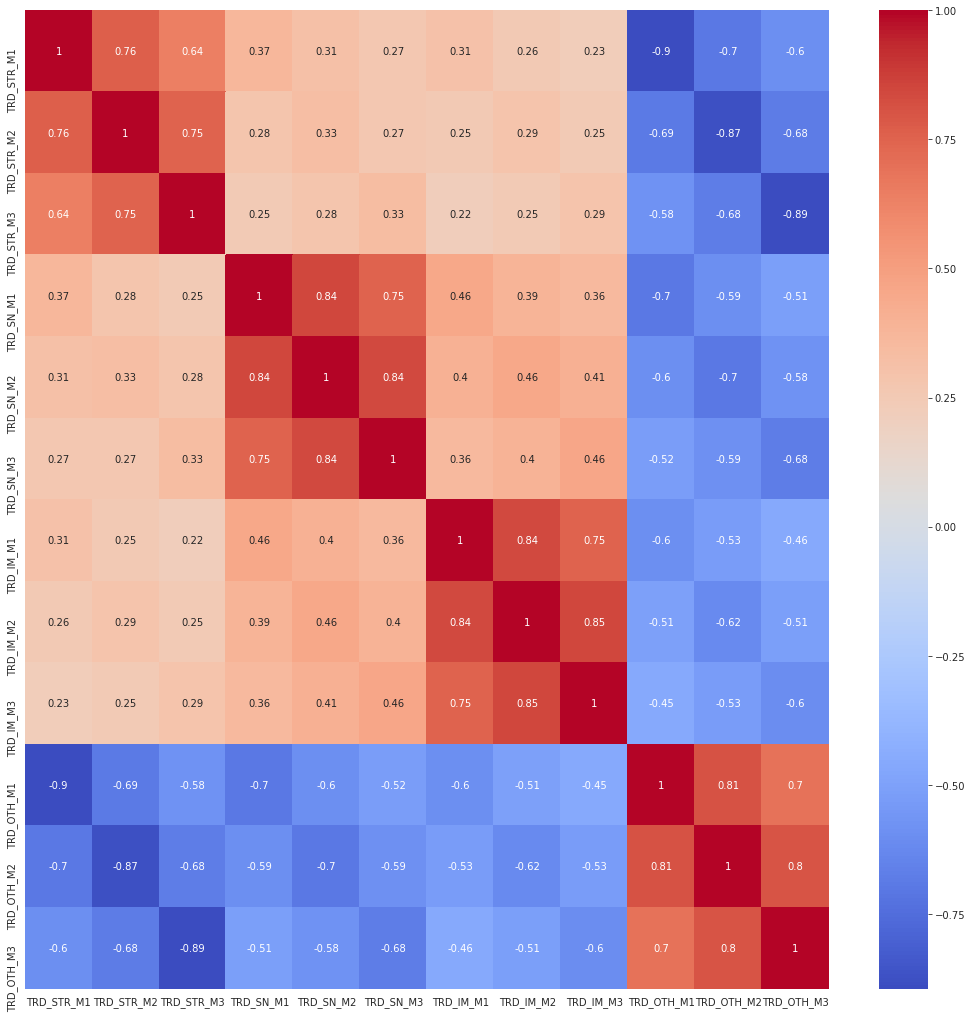

In [69]:
# FIXME: Corroborar que estas columnas tienen el total de los datos
total_data_columns = ['TRD_M1', 'TRD_M2', 'TRD_M3']
df_traffic_data_columns = [traffic_column for traffic_column in traffic_columns 
                           if traffic_column.startswith("TRD") 
                           and traffic_column not in  total_data_columns]
df_traffic_data_corr  = df_traffic[df_traffic_data_columns].corr()
# df_traffic_data_corr
plt.figure(figsize=(18, 18))
sns.heatmap(df_traffic_data_corr, annot=True, cmap='coolwarm')

Función que devuelve dos últimos elementos de iterable, en este caso mes de las columnas

In [70]:
get_month = lambda x: x[-2:]

**Tráfico de datos agrupados por mes**

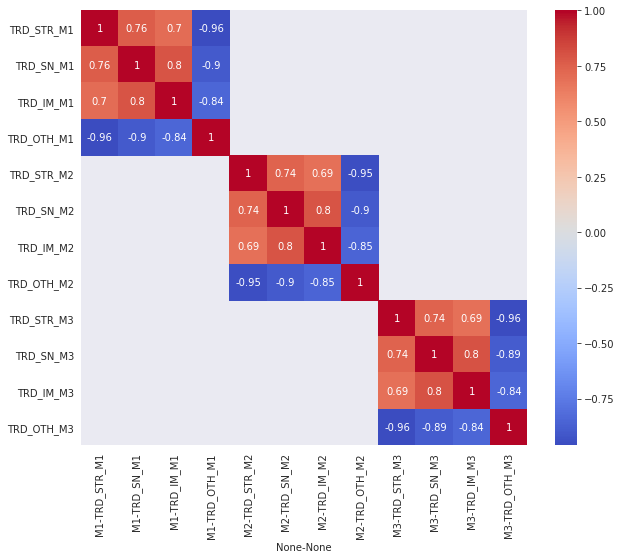

In [71]:
by_month_traffic_data_corr = df_traffic_data_corr.groupby(by=get_month, axis=1).corr()
# by_month_traffic_data_corr
plt.figure(figsize=(10, 8))
sns.heatmap(by_month_traffic_data_corr, annot=True, cmap='coolwarm')

Las variables de consumo de datos agrupadas por mes tienen una correlación bastante alta por lo que se los puede agrupar por mes.

**Número de SMS agrupados por tipo**

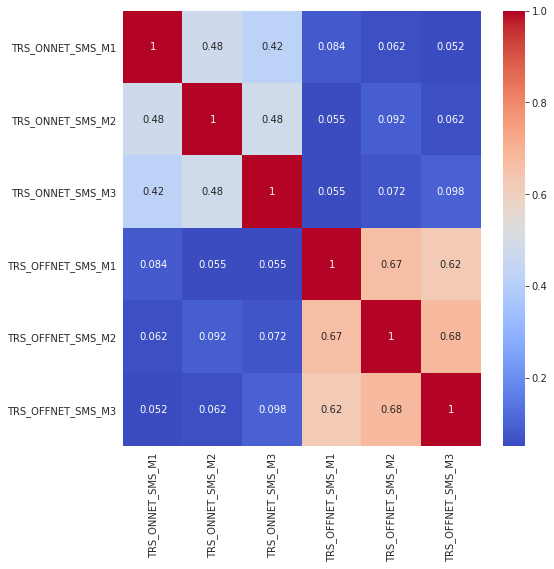

In [72]:
df_n_sms_columns = [traffic_column for traffic_column in traffic_columns if traffic_column.startswith("TRS")]
df_n_sms_corr  = df_traffic[df_n_sms_columns].corr()
# df_n_sms_corr
plt.figure(figsize=(8, 8))
sns.heatmap(df_n_sms_corr, annot=True, cmap='coolwarm')

### Número de SMS agrupados por mes

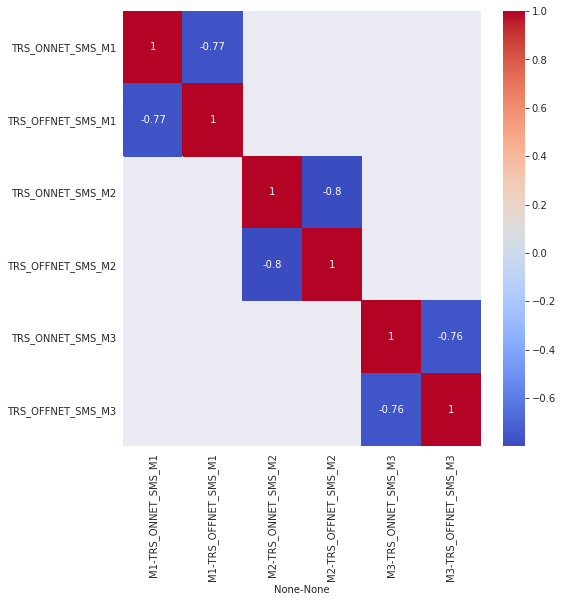

In [73]:
by_month_n_sms_corr = df_n_sms_corr.groupby(by=get_month, axis=1).corr()
# by_month_n_sms_corr
plt.figure(figsize=(8, 8))
sns.heatmap(by_month_n_sms_corr, annot=True, cmap='coolwarm')

In [74]:
df_traffic[df_n_sms_columns].describe()

,TRS_ONNET_SMS_M1,TRS_ONNET_SMS_M2,TRS_ONNET_SMS_M3,TRS_OFFNET_SMS_M1,TRS_OFFNET_SMS_M2,TRS_OFFNET_SMS_M3
count,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000
mean,0.173415,0.185037,0.191791,1.216655,1.198780,1.216179
std,0.949936,0.983975,1.002220,2.403954,2.400983,2.459793
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,26.000000,36.000000,36.000000,37.000000,38.000000,30.000000


_Como los datos de SMS están acumulados en torno a cero, se descartarán estas columnas_

**Llamadas por voz agrupadas por tipo**

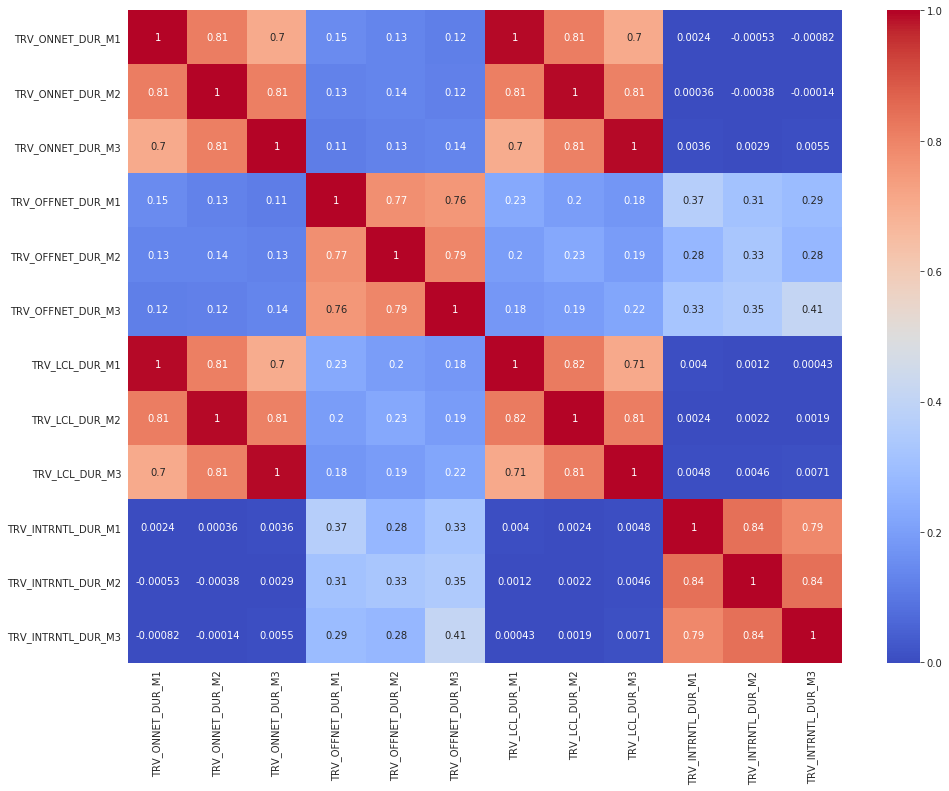

In [75]:
df_voice_minutes_columns = [traffic_column for traffic_column in traffic_columns if traffic_column.startswith("TRV")]
df_voice_minutes_corr = df_traffic[df_voice_minutes_columns].corr()
# df_n_sms_corr
plt.figure(figsize=(16, 12))
sns.heatmap(df_voice_minutes_corr, annot=True, cmap='coolwarm')

**Llamadas por voz agrupadas por mes**

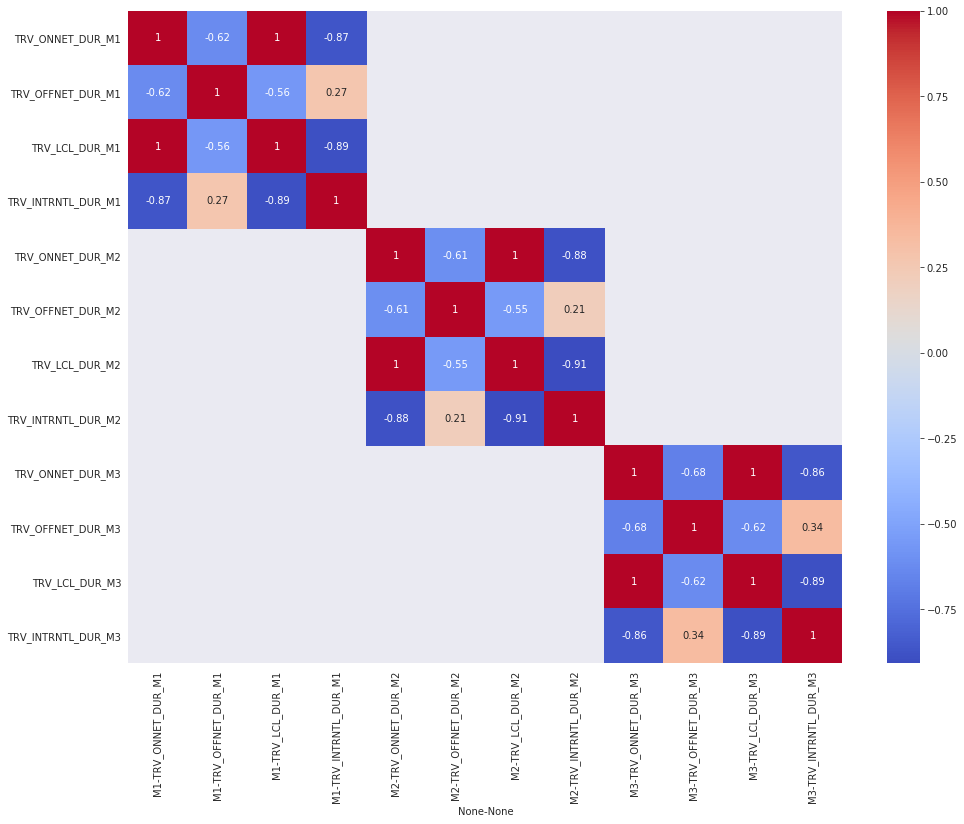

In [76]:
by_month_voice_minutes_corr = df_voice_minutes_corr.groupby(by=get_month, axis=1).corr()
# by_month_n_sms_corr
plt.figure(figsize=(16, 12))
sns.heatmap(by_month_voice_minutes_corr, annot=True, cmap='coolwarm')

### Las llamamdas tienen también una alta correlación entre sí por mes, por lo que se podrían agrupar por columnas por mes

--------------------------

# Outliers

## Tráfico de datos

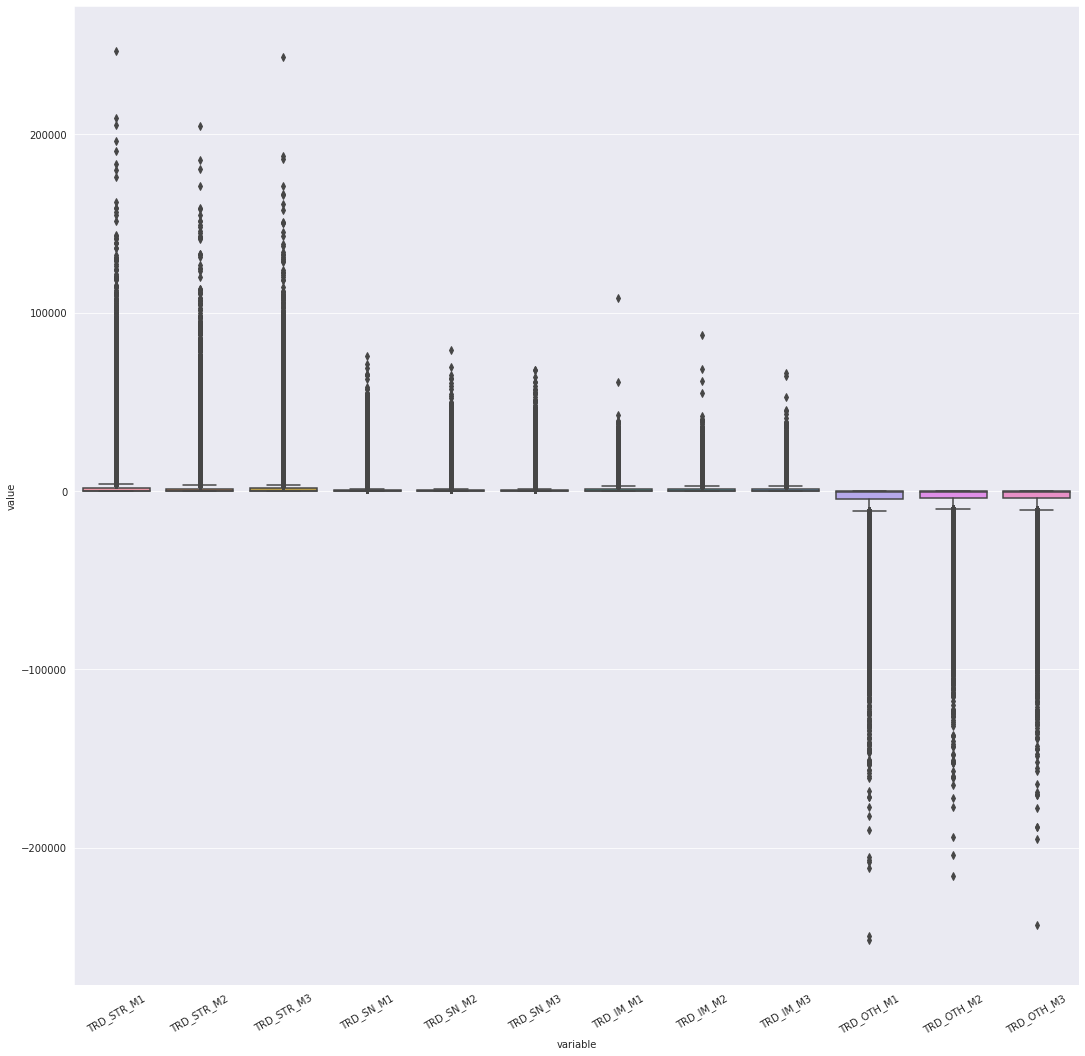

In [77]:
plt.figure(figsize=(18,18))
ax = sns.boxplot(x="variable", y="value", data=pd.melt(df_traffic[df_traffic_data_columns]))
ax = ax.set_xticklabels(ax.get_xticklabels(),rotation=30)

## Llamadas por voz

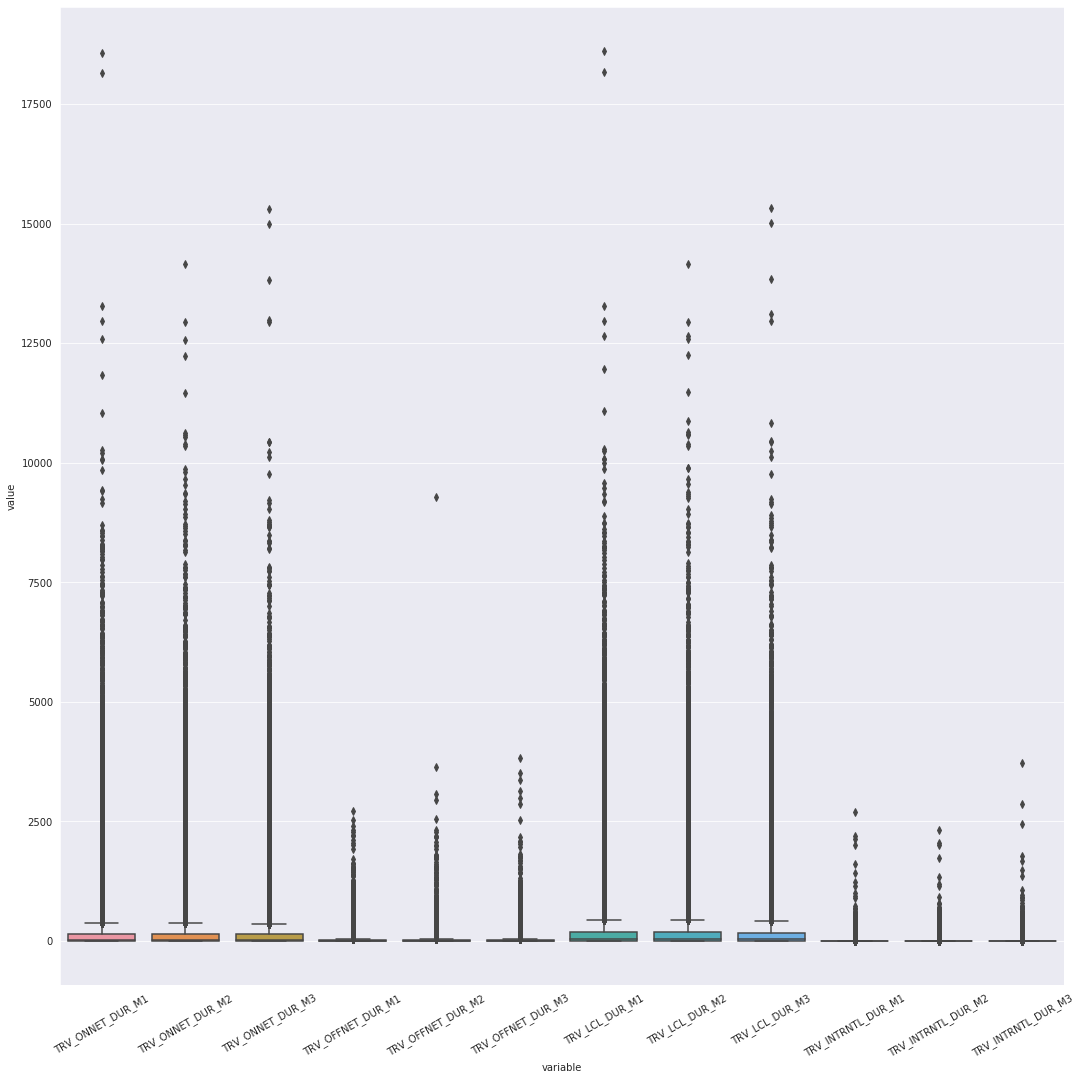

In [78]:
plt.figure(figsize=(18,18))
ax = sns.boxplot(x="variable", y="value", data=pd.melt(df_traffic[df_voice_minutes_columns]))
ax = ax.set_xticklabels(ax.get_xticklabels(),rotation=30)

## Sacando outliers

In [79]:
df_traffic_copy = df_traffic.copy()

In [80]:
df_traffic_data = pd.DataFrame()
for column in df_traffic[df_traffic_data_columns]:
    Q1 = df_traffic[column].quantile(0.25)
    Q3 = df_traffic[column].quantile(0.75)
    IQR = Q3 - Q1
    df_traffic_data[column] = np.where((df_traffic[column] < (Q1 - 1.5 * IQR)) | (df_traffic[column] > (Q3 + 1.5 * IQR)), df_traffic[column].median(), df_traffic[column])


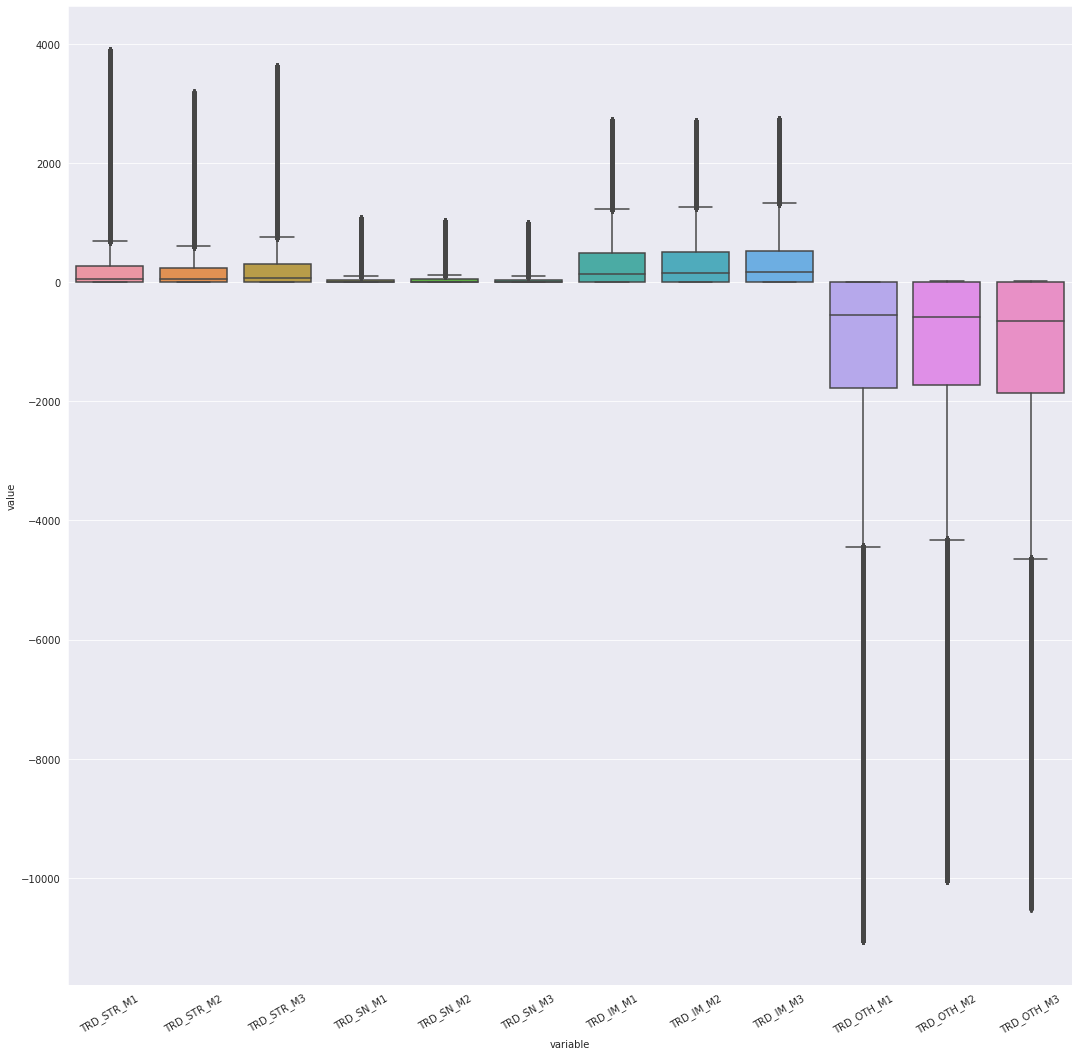

In [81]:
plt.figure(figsize=(18,18))
ax = sns.boxplot(x="variable", y="value", data=pd.melt(df_traffic_data))
ax = ax.set_xticklabels(ax.get_xticklabels(),rotation=30)

In [82]:
df_voice_data = pd.DataFrame()
for column in df_traffic[df_voice_minutes_columns]:
    Q1 = df_traffic[column].quantile(0.25)
    Q3 = df_traffic[column].quantile(0.75)
    IQR = Q3 - Q1
    df_voice_data[column] = np.where((df_traffic[column] < (Q1 - 1.5 * IQR)) | (df_traffic[column] > (Q3 + 1.5 * IQR)), df_traffic[column].median(), df_traffic[column])


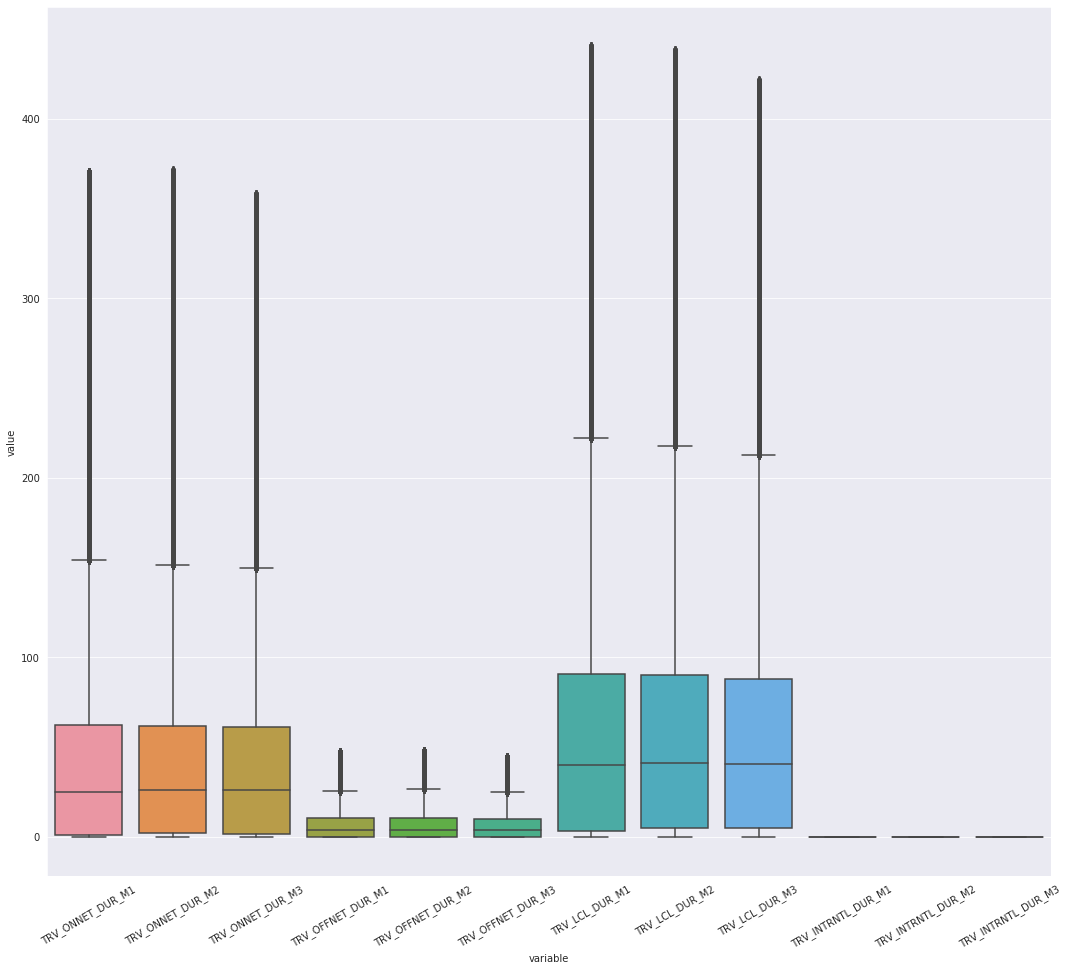

In [83]:
plt.figure(figsize=(18,16))
ax = sns.boxplot(x="variable", y="value", data=pd.melt(df_voice_data))
ax = ax.set_xticklabels(ax.get_xticklabels(),rotation=30)

**Sacando datos de fulldata**

In [84]:
fulldata.drop(columns=traffic_columns, inplace=True)

In [85]:
df_traffic.drop(columns=df_n_sms_columns, inplace=True)

In [86]:
fulldata.join(other=df_traffic)

,SUSCRIBER_KEY,LAT_PROV_BTS,LON_PROV_BTS,LAT_CITY_BTS,LON_CITY_BTS,VALUE_SEGMENT,SEGMENTATION,MICROSEGMENTATION,DEVICE_MODEL_NAME,DEVICE_VENDOR_NAME,NETWORK_TECH,COMMERCIAL_ACTIVATION_DATE,TENURE_CUSTOMER,TENURE_CUSTOMER_BL,PREP_RECH_Q_EVT_X1,...,TRD_OTH_M1,TRD_OTH_M2,TRD_OTH_M3,TRV_ONNET_DUR_M1,TRV_ONNET_DUR_M2,TRV_ONNET_DUR_M3,TRV_OFFNET_DUR_M1,TRV_OFFNET_DUR_M2,TRV_OFFNET_DUR_M3,TRV_LCL_DUR_M1,TRV_LCL_DUR_M2,TRV_LCL_DUR_M3,TRV_INTRNTL_DUR_M1,TRV_INTRNTL_DUR_M2,TRV_INTRNTL_DUR_M3
0,E_63734494_20190215,8.58480,-82.38850,-82.43330,8.43330,3 - SILVER,2-PD,PD1,G4 STYLUS (H540),LG,LTE,15-FEB-19,8,8,6,...,-13044.91,-1582.94,-863.00,139.53,188.60,1.67,8.33,21.95,1.13,147.87,210.55,2.80,0.0,0.0,0.0
1,E_66977552_20190518,8.58480,-82.38850,-82.43330,8.43330,4 - BRONZE,7-LOW,LOW3,GALAXY GRAND PRIME DUOS (SM-G532M DS),SAMSUNG,LTE,18-MAY-19,5,5,0,...,0.00,0.00,0.00,0.00,0.00,0.00,2.27,4.12,0.62,2.27,4.12,0.62,0.0,0.0,0.0
2,E_69159695_20180116,8.12310,-81.07550,-78.16140,8.65525,3 - SILVER,6-OH,LOW4,GALAXY GRAND PRIME DUOS (SM-G532M DS),SAMSUNG,3G,16-JAN-18,21,21,6,...,-296.58,0.00,-64.91,1.38,0.00,0.68,8.00,3.28,0.20,9.38,3.28,0.88,0.0,0.0,0.0
3,E_65255730_20190416,9.08320,-79.59240,-79.51973,8.99360,3 - SILVER,7-LOW,LOW3,JENNY TV 2.8,BLU,LTE,16-APR-19,6,6,4,...,-119.86,0.00,0.00,1.17,0.00,0.00,0.00,0.00,0.00,1.17,0.00,0.00,0.0,0.0,0.0
4,E_67893872_20161201,9.08320,-79.59240,-79.51973,8.99360,3 - SILVER,3-DO,DO3,GALAXY J1 (SM-J111MDS),SAMSUNG,LTE,01-DEC-16,35,35,4,...,-1349.20,-2888.10,-684.12,0.00,0.00,12.05,0.00,0.08,0.00,0.00,0.08,12.05,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319217,E_66690182_20190121,9.41650,-82.52070,-82.52000,9.43000,4 - BRONZE,7-LOW,LOW4,GALAXY GRAND NEO (GT-I9060C),SAMSUNG,LTE,21-JAN-19,9,9,0,...,0.00,-84.47,-167.11,0.00,0.00,1.12,0.00,0.00,2.32,0.00,0.00,3.43,0.0,0.0,0.0
319218,E_65347728_20171017,9.08320,-79.59240,-79.51973,8.99360,3 - SILVER,3-DO,VD3,GALAXY J2 PRIME (SM-G532M),SAMSUNG,LTE,17-OCT-17,24,24,4,...,-1176.77,-3725.94,-3872.93,133.38,186.70,177.43,0.47,7.82,14.67,133.85,194.52,192.10,0.0,0.0,0.0
319219,E_68063707_20150701,8.79528,-80.14711,-79.65000,8.95000,3 - SILVER,6-OH,OH2,GT-E1205Q,SAMSUNG,LTE,01-JUL-15,52,52,6,...,0.00,0.00,0.00,91.50,28.77,36.33,1.00,1.07,0.42,92.50,29.83,36.75,0.0,0.0,0.0
319220,E_67206080_20181010,7.86810,-77.83670,-77.67270,8.13930,4 - BRONZE,7-LOW,VD1,Y9 2019 (JKM-LX3),HUAWEI,LTE,10-OCT-18,12,12,0,...,0.00,0.00,-3523.03,0.00,0.00,433.30,0.00,0.00,18.17,0.00,0.00,451.47,0.0,0.0,0.0


---

# Limpieza de datos de recargas

---

In [87]:
recargas_columns = [recarga_column for recarga_column in fulldata.columns if recarga_column.startswith("PREP")]
Recargas = fulldata[recargas_columns].copy()

In [88]:
Cant_rec_mes1= Recargas[['PREP_RECH_Q_EVT_W1','PREP_RECH_Q_EVT_W2','PREP_RECH_Q_EVT_W3','PREP_RECH_Q_EVT_W4'
                        ]].sum(axis=1)
Cant_rec_mes2= Recargas[['PREP_RECH_Q_EVT_W5','PREP_RECH_Q_EVT_W6','PREP_RECH_Q_EVT_W7','PREP_RECH_Q_EVT_W8'
                        ]].sum(axis=1)
Cant_rec_mes3= Recargas[['PREP_RECH_Q_EVT_W9','PREP_RECH_Q_EVT_W10','PREP_RECH_Q_EVT_W11','PREP_RECH_Q_EVT_W12'
                        ]].sum(axis=1)

In [89]:
(Cant_rec_mes1 == Recargas['PREP_RECH_Q_EVT_X1']).value_counts()

False    191491
True     127731
dtype: int64

In [90]:
(Cant_rec_mes2 == Recargas['PREP_RECH_Q_EVT_X2']).value_counts()

False    192949
True     126273
dtype: int64

In [91]:
(Cant_rec_mes3 == Recargas['PREP_RECH_Q_EVT_X3']).value_counts()

False    201542
True     117680
dtype: int64

Consideramos que la cantidad de datos que no coinciden es apreciable, entonces decidimos sacar los datos

In [92]:
fulldata.drop(columns=[x for x in fulldata.columns if 'PREP_RECH_Q_EVT_X' in x],inplace=True)
fulldata.drop(columns=[x for x in fulldata.columns if 'PREP_RECH_Q_EVT_W' in x],inplace=True)

**Vamos a comparar los montos de recargas acumuladas, con los montos de recargas acumuladas mensuales**

In [93]:
Mont_rec_mes1= Recargas[['PREP_RECH_AMT_W1','PREP_RECH_AMT_W2','PREP_RECH_AMT_W3','PREP_RECH_AMT_W4'
                        ]].sum(axis=1)

In [94]:
Mont_rec_mes2= Recargas[['PREP_RECH_AMT_W5','PREP_RECH_AMT_W6','PREP_RECH_AMT_W7','PREP_RECH_AMT_W8'
                        ]].sum(axis=1)

In [95]:
Mont_rec_mes3= Recargas[['PREP_RECH_AMT_W9','PREP_RECH_AMT_W10','PREP_RECH_AMT_W11','PREP_RECH_AMT_W12'
                        ]].sum(axis=1)

In [96]:
(Mont_rec_mes1 == Recargas['PREP_RECH_AMT_X1']).value_counts()

True     319070
False       152
dtype: int64

In [97]:
(Mont_rec_mes2 == Recargas['PREP_RECH_AMT_X2']).value_counts()

True     319061
False       161
dtype: int64

In [98]:
(Mont_rec_mes3 == Recargas['PREP_RECH_AMT_X3']).value_counts()

True     319059
False       163
dtype: int64

Como los valores difieren en una cantidad indistinguible(menos del 1%) podemos conciderar que presentan la misma información. Por tal motivo se decide sacar las columnas de montos acumulados

In [99]:
fulldata.drop(columns=[x for x in fulldata.columns if 'PREP_RECH_AMT_X' in x],inplace=True)

In [100]:
fulldata.shape

(319222, 85)

**Seguimos trabajando con las recargas**

Eliminamos en el dataframe de recargas, las mismas columnas que eliminamos en el fulldata

In [101]:
def Borrar_columnas(df, grupo_de_columnas):
    df.drop(columns=[x for x in Recargas.columns if grupo_de_columnas in x],inplace=True)

In [102]:
Borrar_columnas(Recargas,'PREP_RECH_AMT_X')
Borrar_columnas(Recargas,'PREP_RECH_Q_EVT_W')
Borrar_columnas(Recargas,'PREP_RECH_Q_EVT_X')

In [103]:
Recargas.shape

(319222, 22)

### Análisis de correlación

*Correlación entre Cantidad de recargas en x día durante las 12 semanas*

In [104]:
Cant_rec_en_dias= Recargas[[x for x in Recargas.columns if 'PREP_RECH_Q' in x]]
Cant_rec_en_dias.describe()

,PREP_RECH_Q_MON_12W,PREP_RECH_Q_TUE_12W,PREP_RECH_Q_WEN_12W,PREP_RECH_Q_THUR_12W,PREP_RECH_Q_FRI_12W,PREP_RECH_Q_SAT_12W,PREP_RECH_Q_SUN_12W
count,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000
mean,2.770473,2.484537,2.536645,2.655685,2.839980,2.566596,2.336622
std,2.633008,2.520506,2.517774,2.534744,2.589916,2.572251,2.470489
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
75%,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
max,39.000000,43.000000,38.000000,37.000000,38.000000,51.000000,38.000000


In [105]:
Cant_rec_en_dias.corr()

,PREP_RECH_Q_MON_12W,PREP_RECH_Q_TUE_12W,PREP_RECH_Q_WEN_12W,PREP_RECH_Q_THUR_12W,PREP_RECH_Q_FRI_12W,PREP_RECH_Q_SAT_12W,PREP_RECH_Q_SUN_12W
PREP_RECH_Q_MON_12W,1.000000,0.379673,0.354563,0.382599,0.351402,0.284211,0.304759
PREP_RECH_Q_TUE_12W,0.379673,1.000000,0.383747,0.352447,0.359342,0.335362,0.277231
PREP_RECH_Q_WEN_12W,0.354563,0.383747,1.000000,0.381315,0.346658,0.328482,0.326740
PREP_RECH_Q_THUR_12W,0.382599,0.352447,0.381315,1.000000,0.381090,0.289958,0.315796
PREP_RECH_Q_FRI_12W,0.351402,0.359342,0.346658,0.381090,1.000000,0.320213,0.283657
PREP_RECH_Q_SAT_12W,0.284211,0.335362,0.328482,0.289958,0.320213,1.000000,0.327095
PREP_RECH_Q_SUN_12W,0.304759,0.277231,0.326740,0.315796,0.283657,0.327095,1.000000


Vemos que los coeficientes de Pearson entre las variables expresan que no hay correlación entre las variables analizadas

### Correlación entre montos acumulados de recargas por semana

In [106]:
Mont_Acum_por_sem= Recargas[[x for x in Recargas.columns if 'PREP_RECH_AMT_W' in x]]
Mont_Acum_por_sem.describe()

,PREP_RECH_AMT_W1,PREP_RECH_AMT_W2,PREP_RECH_AMT_W3,PREP_RECH_AMT_W4,PREP_RECH_AMT_W5,PREP_RECH_AMT_W6,PREP_RECH_AMT_W7,PREP_RECH_AMT_W8,PREP_RECH_AMT_W9,PREP_RECH_AMT_W10,PREP_RECH_AMT_W11,PREP_RECH_AMT_W12
count,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000
mean,2.732087,3.217064,2.817290,3.549195,2.998092,3.173191,2.840202,3.345359,3.122188,3.111067,3.377898,3.160723
std,3.857857,4.218097,3.879877,4.514366,4.087966,4.171063,3.952560,4.252033,4.167941,4.133527,4.239955,4.122492
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,3.000000,0.000000,3.000000,1.500000,2.000000,0.000000,3.000000,2.000000,2.000000,3.000000,3.000000
75%,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
max,85.000000,345.000000,133.000000,170.000000,98.000000,168.220000,125.000000,123.690000,150.000000,120.000000,210.000000,115.000000


In [107]:
Mont_Acum_por_sem.corr()

,PREP_RECH_AMT_W1,PREP_RECH_AMT_W2,PREP_RECH_AMT_W3,PREP_RECH_AMT_W4,PREP_RECH_AMT_W5,PREP_RECH_AMT_W6,PREP_RECH_AMT_W7,PREP_RECH_AMT_W8,PREP_RECH_AMT_W9,PREP_RECH_AMT_W10,PREP_RECH_AMT_W11,PREP_RECH_AMT_W12
PREP_RECH_AMT_W1,1.000000,0.387587,0.450786,0.404695,0.449589,0.418191,0.389979,0.362100,0.379022,0.389557,0.352022,0.336874
PREP_RECH_AMT_W2,0.387587,1.000000,0.416184,0.460712,0.431145,0.462956,0.418715,0.406668,0.385504,0.374179,0.413962,0.332321
PREP_RECH_AMT_W3,0.450786,0.416184,1.000000,0.398843,0.461153,0.423277,0.450026,0.412411,0.397969,0.383072,0.376044,0.384792
PREP_RECH_AMT_W4,0.404695,0.460712,0.398843,1.000000,0.428096,0.456106,0.411002,0.473736,0.432682,0.384098,0.394640,0.356400
PREP_RECH_AMT_W5,0.449589,0.431145,0.461153,0.428096,1.000000,0.426950,0.454438,0.419277,0.459938,0.432653,0.397538,0.377575
PREP_RECH_AMT_W6,0.418191,0.462956,0.423277,0.456106,0.426950,1.000000,0.416285,0.435692,0.432031,0.443515,0.436375,0.376568
PREP_RECH_AMT_W7,0.389979,0.418715,0.450026,0.411002,0.454438,0.416285,1.000000,0.390575,0.450066,0.419207,0.440426,0.408003
PREP_RECH_AMT_W8,0.362100,0.406668,0.412411,0.473736,0.419277,0.435692,0.390575,1.000000,0.406533,0.431688,0.407624,0.415469
PREP_RECH_AMT_W9,0.379022,0.385504,0.397969,0.432682,0.459938,0.432031,0.450066,0.406533,1.000000,0.426734,0.446665,0.414405
PREP_RECH_AMT_W10,0.389557,0.374179,0.383072,0.384098,0.432653,0.443515,0.419207,0.431688,0.426734,1.000000,0.402197,0.437371


Los coeficientes de Pearson entre las variables expresan que no hay correlación entre ellas.

### Outliers

**Cantidad de recargas en x dias durante las 12 semanas**

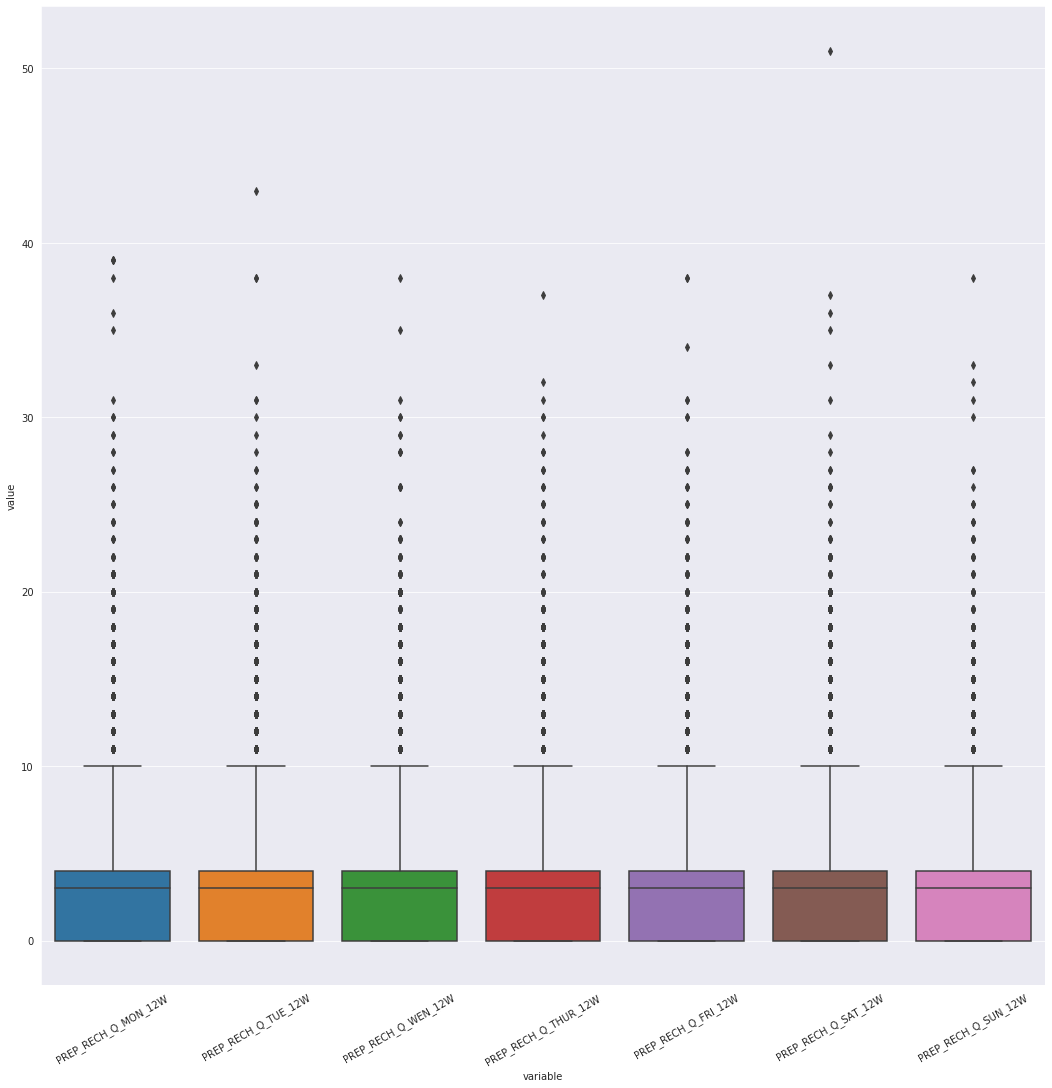

In [108]:
plt.figure(figsize=(18,18))
ax = sns.boxplot(x="variable", y="value", data=pd.melt(Cant_rec_en_dias))
ax = ax.set_xticklabels(ax.get_xticklabels(),rotation=30)

In [109]:
Cant_rec_en_dias.describe()

,PREP_RECH_Q_MON_12W,PREP_RECH_Q_TUE_12W,PREP_RECH_Q_WEN_12W,PREP_RECH_Q_THUR_12W,PREP_RECH_Q_FRI_12W,PREP_RECH_Q_SAT_12W,PREP_RECH_Q_SUN_12W
count,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000
mean,2.770473,2.484537,2.536645,2.655685,2.839980,2.566596,2.336622
std,2.633008,2.520506,2.517774,2.534744,2.589916,2.572251,2.470489
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
75%,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
max,39.000000,43.000000,38.000000,37.000000,38.000000,51.000000,38.000000


Vemos que en todas las columnas el rango intercuartil es 4. Así que vamos a ver cuantas mediciones superan en 1.5 veces el rango (y lo dividimos por el total de filas para obtener una frecuencia relativa). 

In [110]:
print(((Recargas['PREP_RECH_Q_MON_12W']>10).value_counts())/ len(Recargas.index),
      ((Recargas['PREP_RECH_Q_TUE_12W']>10).value_counts())/ len(Recargas.index),
      ((Recargas['PREP_RECH_Q_WEN_12W']>10).value_counts())/ len(Recargas.index),
      ((Recargas['PREP_RECH_Q_THUR_12W']>10).value_counts())/ len(Recargas.index),
      ((Recargas['PREP_RECH_Q_FRI_12W']>10).value_counts())/ len(Recargas.index),
      ((Recargas['PREP_RECH_Q_SAT_12W']>10).value_counts())/ len(Recargas.index),
      ((Recargas['PREP_RECH_Q_SUN_12W']>10).value_counts())/ len(Recargas.index)
     )

False    0.990702
True     0.009298
Name: PREP_RECH_Q_MON_12W, dtype: float64 False    0.993935
True     0.006065
Name: PREP_RECH_Q_TUE_12W, dtype: float64 False    0.993234
True     0.006766
Name: PREP_RECH_Q_WEN_12W, dtype: float64 False    0.993221
True     0.006779
Name: PREP_RECH_Q_THUR_12W, dtype: float64 False    0.991821
True     0.008179
Name: PREP_RECH_Q_FRI_12W, dtype: float64 False    0.9923
True     0.0077
Name: PREP_RECH_Q_SAT_12W, dtype: float64 False    0.99412
True     0.00588
Name: PREP_RECH_Q_SUN_12W, dtype: float64


Además veamos el coeficiente de variación.

In [111]:
(Recargas['PREP_RECH_Q_MON_12W'].std()/Recargas['PREP_RECH_Q_MON_12W'].mean())*100

95.03818759314608

**Se calcula uno sólo, pero al ver la tabla del "describe" se puede notar que los demás coeficientes también son superiores al 90%. Por lo tanto, se igualará a todos los valores superiores a dos veces el rango, por el valor de 4+2*R, con el objetivo de influir lo menos posible en la distribución, y que los valores atípicos no influyan de manera apreciable en la media y desvío estándar.**

In [112]:
fulldata = fulldata[fulldata['PREP_RECH_Q_MON_12W']<=10]
fulldata = fulldata[fulldata['PREP_RECH_Q_TUE_12W']<=10]
fulldata = fulldata[fulldata['PREP_RECH_Q_WEN_12W']<=10]
fulldata = fulldata[fulldata['PREP_RECH_Q_THUR_12W']<=10]
fulldata = fulldata[fulldata['PREP_RECH_Q_FRI_12W']<=10]
fulldata = fulldata[fulldata['PREP_RECH_Q_SAT_12W']<=10]
fulldata = fulldata[fulldata['PREP_RECH_Q_SUN_12W']<=10]

Confirmamos que no hay valores superiores a 10

In [113]:
((fulldata['PREP_RECH_Q_SAT_12W']>10).value_counts())/ len(fulldata.index)

False    1.0
Name: PREP_RECH_Q_SAT_12W, dtype: float64

### Monto acumulado de recargas por semana


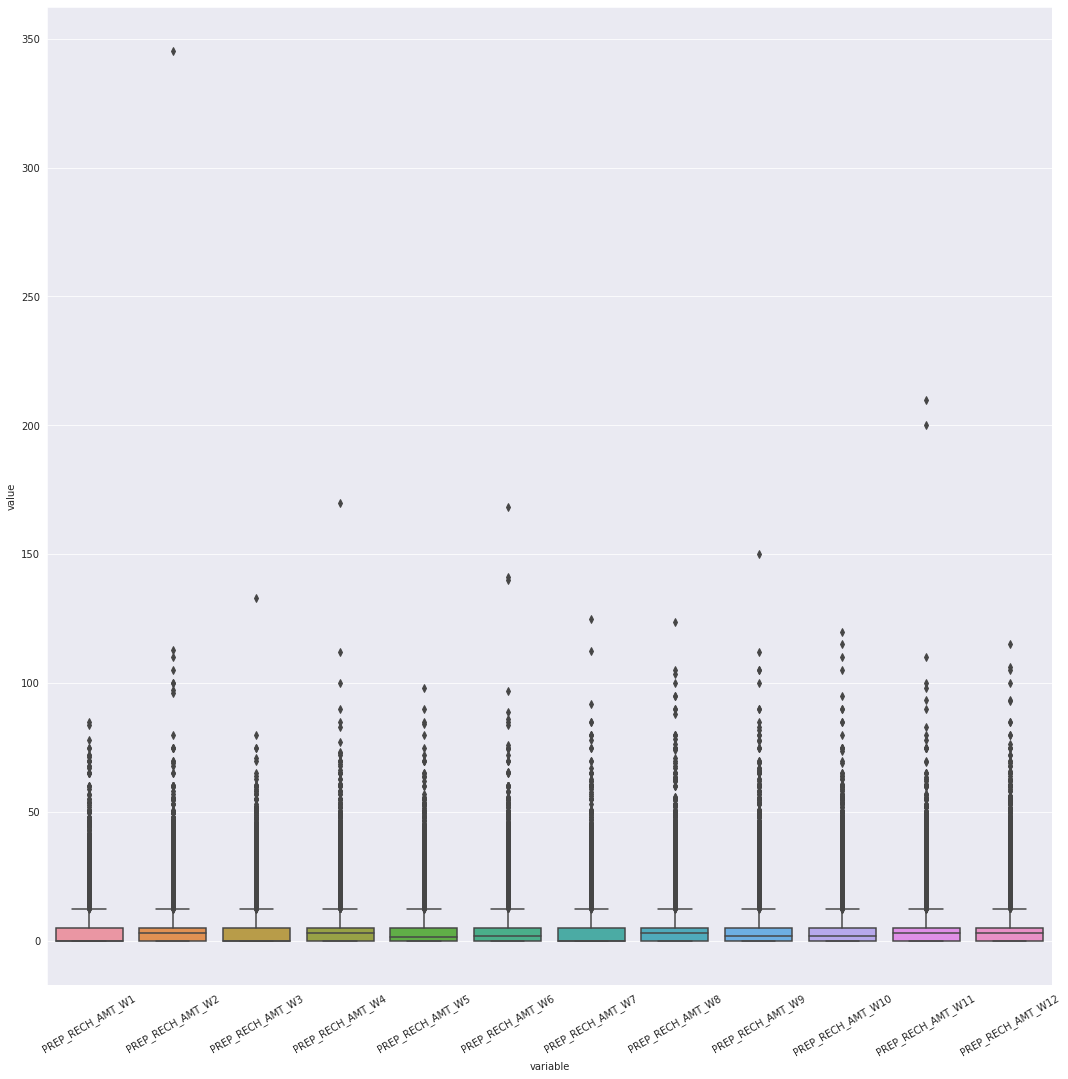

In [114]:
plt.figure(figsize=(18,18))
ax = sns.boxplot(x="variable", y="value", data=pd.melt(Mont_Acum_por_sem))
ax = ax.set_xticklabels(ax.get_xticklabels(),rotation=30)

In [115]:
Mont_Acum_por_sem.describe()

,PREP_RECH_AMT_W1,PREP_RECH_AMT_W2,PREP_RECH_AMT_W3,PREP_RECH_AMT_W4,PREP_RECH_AMT_W5,PREP_RECH_AMT_W6,PREP_RECH_AMT_W7,PREP_RECH_AMT_W8,PREP_RECH_AMT_W9,PREP_RECH_AMT_W10,PREP_RECH_AMT_W11,PREP_RECH_AMT_W12
count,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000
mean,2.732087,3.217064,2.817290,3.549195,2.998092,3.173191,2.840202,3.345359,3.122188,3.111067,3.377898,3.160723
std,3.857857,4.218097,3.879877,4.514366,4.087966,4.171063,3.952560,4.252033,4.167941,4.133527,4.239955,4.122492
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,3.000000,0.000000,3.000000,1.500000,2.000000,0.000000,3.000000,2.000000,2.000000,3.000000,3.000000
75%,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
max,85.000000,345.000000,133.000000,170.000000,98.000000,168.220000,125.000000,123.690000,150.000000,120.000000,210.000000,115.000000


In [116]:
print(((Recargas['PREP_RECH_AMT_W1']>12.5).value_counts())/ len(Recargas.index),
      ((Recargas['PREP_RECH_AMT_W2']>12.5).value_counts())/ len(Recargas.index),
      ((Recargas['PREP_RECH_AMT_W3']>12.5).value_counts())/ len(Recargas.index),
      ((Recargas['PREP_RECH_AMT_W4']>12.5).value_counts())/ len(Recargas.index),
      ((Recargas['PREP_RECH_AMT_W5']>12.5).value_counts())/ len(Recargas.index),
      ((Recargas['PREP_RECH_AMT_W6']>12.5).value_counts())/ len(Recargas.index),
      ((Recargas['PREP_RECH_AMT_W7']>12.5).value_counts())/ len(Recargas.index),
      ((Recargas['PREP_RECH_AMT_W8']>12.5).value_counts())/ len(Recargas.index),
      ((Recargas['PREP_RECH_AMT_W9']>12.5).value_counts())/ len(Recargas.index),
      ((Recargas['PREP_RECH_AMT_W10']>12.5).value_counts())/ len(Recargas.index),
      ((Recargas['PREP_RECH_AMT_W11']>12.5).value_counts())/ len(Recargas.index),
      ((Recargas['PREP_RECH_AMT_W12']>12.5).value_counts())/ len(Recargas.index)
     )

False    0.976346
True     0.023654
Name: PREP_RECH_AMT_W1, dtype: float64 False    0.968893
True     0.031107
Name: PREP_RECH_AMT_W2, dtype: float64 False    0.975901
True     0.024099
Name: PREP_RECH_AMT_W3, dtype: float64 False    0.957829
True     0.042171
Name: PREP_RECH_AMT_W4, dtype: float64 False    0.971064
True     0.028936
Name: PREP_RECH_AMT_W5, dtype: float64 False    0.969798
True     0.030202
Name: PREP_RECH_AMT_W6, dtype: float64 False    0.974748
True     0.025252
Name: PREP_RECH_AMT_W7, dtype: float64 False    0.967248
True     0.032752
Name: PREP_RECH_AMT_W8, dtype: float64 False    0.970362
True     0.029638
Name: PREP_RECH_AMT_W9, dtype: float64 False    0.970691
True     0.029309
Name: PREP_RECH_AMT_W10, dtype: float64 False    0.967029
True     0.032971
Name: PREP_RECH_AMT_W11, dtype: float64 False    0.97086
True     0.02914
Name: PREP_RECH_AMT_W12, dtype: float64


Además veamos el coeficiente de variación.

In [117]:
(Recargas['PREP_RECH_AMT_W1'].std()/Recargas['PREP_RECH_AMT_W1'].mean())*100

141.2055207208845

**Se calcula uno sólo, pero al ver la tabla del "describe" se puede notar que los demás coeficientes son muy altos, debido a que el desvío estándar es superior a la media.**

In [118]:
fulldata = fulldata[fulldata['PREP_RECH_AMT_W1']<=12.5]
fulldata = fulldata[fulldata['PREP_RECH_AMT_W2']<=12.5]
fulldata = fulldata[fulldata['PREP_RECH_AMT_W3']<=12.5]
fulldata = fulldata[fulldata['PREP_RECH_AMT_W4']<=12.5]
fulldata = fulldata[fulldata['PREP_RECH_AMT_W5']<=12.5]
fulldata = fulldata[fulldata['PREP_RECH_AMT_W6']<=12.5]
fulldata = fulldata[fulldata['PREP_RECH_AMT_W7']<=12.5]
fulldata = fulldata[fulldata['PREP_RECH_AMT_W8']<=12.5]
fulldata = fulldata[fulldata['PREP_RECH_AMT_W9']<=12.5]
fulldata = fulldata[fulldata['PREP_RECH_AMT_W10']<=12.5]
fulldata = fulldata[fulldata['PREP_RECH_AMT_W11']<=12.5]
fulldata = fulldata[fulldata['PREP_RECH_AMT_W12']<=12.5]

Confirmamos que no hay valores superiores a 12.5

In [119]:
((fulldata['PREP_RECH_AMT_W12']>12.5).value_counts())/ len(fulldata.index)

False    1.0
Name: PREP_RECH_AMT_W12, dtype: float64

**Días desde la última recarga**

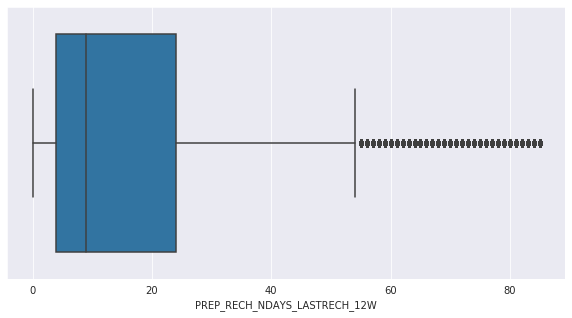

In [120]:
plt.figure(figsize=(10,5))
ax = sns.boxplot(x=Recargas['PREP_RECH_NDAYS_LASTRECH_12W'])

In [121]:
Recargas['PREP_RECH_NDAYS_LASTRECH_12W'].describe()

count    319222.000000
mean         17.858826
std          20.374863
min           0.000000
25%           4.000000
50%           9.000000
75%          24.000000
max          85.000000
Name: PREP_RECH_NDAYS_LASTRECH_12W, dtype: float64

**Se decide no modificar la columna, debido a que el valor máximo que asume la varible es 85, está muy cerca de 3*R+Q3**

---

# Tratamiento de filas según fecha de alta

 ---

Se trabajará la columna de fechas de alta del fulldata

In [122]:
## Se hará que python interprete a la columna de activación comercial como fecha
fulldata['Date'] = pd.to_datetime(fulldata['COMMERCIAL_ACTIVATION_DATE'], format='%d-%b-%y') 
fulldata['Dayofweek'] = fulldata['Date'].dt.dayofweek 
fulldata['Month'] = fulldata['Date'].dt.month 
fulldata['Year'] = fulldata['Date'].dt.year 
fulldata['Period'] = fulldata['Date'].dt.to_period('M') 
fulldata.sort_values('Date', inplace=True) 

In [123]:
fulldata[['COMMERCIAL_ACTIVATION_DATE', 'Date', 'Dayofweek', 'Month', 'Year', 'Period']]

,COMMERCIAL_ACTIVATION_DATE,Date,Dayofweek,Month,Year,Period
287516,10-JUL-11,2011-07-10,6,7,2011,2011-07
171412,10-JUL-11,2011-07-10,6,7,2011,2011-07
298876,25-NOV-11,2011-11-25,4,11,2011,2011-11
208386,22-APR-12,2012-04-22,6,4,2012,2012-04
255393,22-APR-12,2012-04-22,6,4,2012,2012-04
...,...,...,...,...,...,...
222276,17-JUN-19,2019-06-17,0,6,2019,2019-06
93458,17-JUN-19,2019-06-17,0,6,2019,2019-06
96407,17-JUN-19,2019-06-17,0,6,2019,2019-06
108583,17-JUN-19,2019-06-17,0,6,2019,2019-06


Ahora usaremos una tabla pivot para calcular la cantidad de activaciones que por mes en cada año

In [124]:
pd.pivot_table(data=fulldata, index=['Year'], columns=['Month'], aggfunc=['size'])

size                                                             \
Month      1       2       3       4        5        6        7       8    
Year                                                                       
2011      NaN     NaN     NaN     NaN      NaN      NaN      2.0     NaN   
2012      NaN     NaN     NaN     4.0      3.0      NaN      NaN     NaN   
2013      NaN     NaN     NaN     NaN      2.0      NaN     21.0     NaN   
2014      NaN     NaN     NaN     NaN      NaN      NaN      NaN     NaN   
2015     11.0     NaN    11.0     NaN   1784.0  24379.0  44742.0  2636.0   
2016   1849.0  1738.0  1816.0  1852.0   5261.0   3215.0   1883.0  2061.0   
2017   2886.0  2704.0  2994.0  2468.0   2598.0   3182.0   2690.0  2947.0   
2018   3989.0  3343.0  4363.0  4202.0   3777.0   4416.0   4974.0  5260.0   
2019   8341.0  8230.0  9861.0  9891.0  11316.0   7611.0      NaN     NaN   

                                       
Month      9       10      11      12  
Year                                   
2011      NaN     NaN     1.0     NaN  
2012      7.0     NaN     NaN     NaN  
2013      NaN     NaN     NaN     NaN  
2014      NaN     NaN    43.0    59.0  
2015   1577.0  1640.0  1598.0  2308.0  
2016   2129.0  2296.0  2159.0  3783.0  
2017   2719.0  3174.0  2868.0  4746.0  
2018   5091.0  5456.0  5704.0  9492.0  
2019      NaN     NaN     NaN     NaN

**Sacaremos todas las filas de los periodos anteriores al periodo en el cual se dan de alta líneas de manera consecutiva**

In [125]:
period = pd.to_datetime('2015-05').to_period('M')
fulldata = fulldata[fulldata['Period']>=period]

In [126]:
pivot_table = pd.pivot_table(data=fulldata, index=['Year'], columns=['Month'], aggfunc=['size'], fill_value=0)
pivot_table

size                                                                 \
Month    1     2     3     4      5      6      7     8     9     10    11   
Year                                                                         
2015      0     0     0     0   1784  24379  44742  2636  1577  1640  1598   
2016   1849  1738  1816  1852   5261   3215   1883  2061  2129  2296  2159   
2017   2886  2704  2994  2468   2598   3182   2690  2947  2719  3174  2868   
2018   3989  3343  4363  4202   3777   4416   4974  5260  5091  5456  5704   
2019   8341  8230  9861  9891  11316   7611      0     0     0     0     0   

             
Month    12  
Year         
2015   2308  
2016   3783  
2017   4746  
2018   9492  
2019      0

In [127]:
total_rows = fulldata.shape[0]
total_rows

261999

Ahora veamos que pasa en términos de frecuencias relativas en la tabla pivot

In [128]:
pivot_table.divide(total_rows) * 100

size                                                               \
Month        1         2         3         4         5         6          7    
Year                                                                           
2015   0.000000  0.000000  0.000000  0.000000  0.680919  9.304997  17.077164   
2016   0.705728  0.663361  0.693132  0.706873  2.008023  1.227104   0.718705   
2017   1.101531  1.032065  1.142752  0.941988  0.991607  1.214508   1.026721   
2018   1.522525  1.275959  1.665274  1.603823  1.441609  1.685503   1.898481   
2019   3.183600  3.141233  3.763755  3.775205  4.319100  2.904973   0.000000   

                                                         
Month        8         9         10        11        12  
Year                                                     
2015   1.006111  0.601911  0.625957  0.609926  0.880919  
2016   0.786644  0.812599  0.876339  0.824049  1.443899  
2017   1.124813  1.037790  1.211455  1.094661  1.811457  
2018   2.007641  1.943137  2.082451  2.177108  3.622915  
2019   0.000000  0.000000  0.000000  0.000000  0.000000

Vemos que la mayoría de las frecuencias relativas son menores que 4,2 y tenemos valores en junio y julio del 2015 muy superiores al 4,2. Por lo tanto, se decide sacar todo el periodo menor a agosto de 2015, por considerarlos datos erroneos que podrían ensuciar el modelo

In [129]:
period = pd.to_datetime('2015-08').to_period('M')
fulldata = fulldata[fulldata['Period']>=period]
print(fulldata.shape[0])

191094


---

## Encoding variables categóricas

---

In [130]:
num_cols = fulldata._get_numeric_data().columns 
cat_columns = list(set(fulldata.columns) - set(num_cols))

In [131]:
fulldata[cat_columns].nunique()

VALUE_SEGMENT                      4
Period                            47
MICROSEGMENTATION                 25
COMMERCIAL_ACTIVATION_DATE      1417
DEVICE_VENDOR_NAME               203
PREP_RECH_LAST_DAY_12W            84
PREP_RECH_CHNNL_MODE12W         3076
NETWORK_TECH                       3
DEVICE_MODEL_NAME               1994
Date                            1417
SEGMENTATION                       7
SUSCRIBER_KEY                 191094
dtype: int64

**Después de inspeccionar estas variables, con imágenes de value counts, nos detenemos en el caso de DEVICE_VENDOR_NAME**

In [132]:
fulldata.DEVICE_VENDOR_NAME.value_counts(normalize=True)[0:10]

SAMSUNG       0.643411
HUAWEI        0.167525
LG            0.050855
BLU           0.035218
NOKIA         0.023638
APPLE         0.013046
UNKNOWN       0.011748
GREYMARKET    0.008179
HYUNDAI       0.007148
ALCATEL       0.005782
Name: DEVICE_VENDOR_NAME, dtype: float64

**Vemos que la mayoria se concentra en 6 marcas, remplazaremos con 'Other' para poder aplicar hot encoding**

In [133]:
n = 6
most_frequent_vendors = fulldata['DEVICE_VENDOR_NAME'].value_counts()[:n].index.tolist()
fulldata.loc[~fulldata["DEVICE_VENDOR_NAME"].isin(most_frequent_vendors), "DEVICE_VENDOR_NAME"] = "Other"

In [134]:
fulldata.DEVICE_VENDOR_NAME.value_counts(normalize=1)

SAMSUNG    0.643411
HUAWEI     0.167525
Other      0.066308
LG         0.050855
BLU        0.035218
NOKIA      0.023638
APPLE      0.013046
Name: DEVICE_VENDOR_NAME, dtype: float64

**Aplicaremos one hot encode a las columnas SEGMENTATION, VALUE_SEGMENT, NETWORK_TECH, DEVICE_VENDOR_NAME**

In [135]:
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    return(res)

In [136]:
fulldata.shape

(191094, 90)

In [137]:
columns_to_encode = ['SEGMENTATION', 'VALUE_SEGMENT', 'NETWORK_TECH', 'DEVICE_VENDOR_NAME']
for column in columns_to_encode: 
    fulldata = encode_and_bind(fulldata, column)
fulldata.shape

(191094, 111)

---

# Correlación variables con target

---

In [138]:
feature_target_correlation = fulldata[fulldata.columns[1:]].corr()['Target'].dropna()
feature_target_correlation.abs().sort_values(ascending=False)[1:16]

PREP_RECH_NDAYS_LASTRECH_12W    0.536245
SEGMENTATION_7-LOW              0.469424
VALUE_SEGMENT_4 - BRONZE        0.409400
PREP_RECH_AMT_W2                0.404933
PACK_DATA_EXP_W1                0.401155
PACK_DATA_EXP_W2                0.396899
PREP_RECH_AMT_W1                0.389707
PACK_DATA_EXP_W3                0.371024
PACK_DATA_AMT_W2                0.369325
PREP_RECH_AMT_W3                0.363041
PREP_RECH_AMT_W4                0.362964
PACK_DATA_AMT_W1                0.358904
PACK_DATA_EXP_W4                0.346014
PACK_DATA_AMT_W3                0.337123
PACK_DATA_AMT_W4                0.330550
Name: Target, dtype: float64

**Vemos que la correlación lineal entre Target y el resto de las columnas es baja para todas las variables. De todas maneras, puede llegar a haber una corrlación no lineal. Y es por eso que dejamos todas estas variables. Arbitrariamente mostramos estos valores con las 15 variables más correlacionadas con Target**

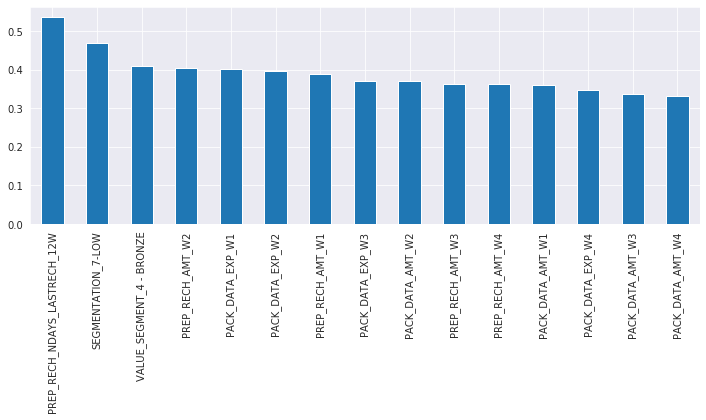

In [139]:
plt.figure(figsize=(12,4))
feature_target_correlation.abs().sort_values(ascending=False)[1:16].plot.bar()

---

# Entrenamos el modelo

---

In [140]:
y=fulldata.Target

In [141]:
columns = [col for col in fulldata.columns if col not in ['SUSCRIBER_KEY','Target']]

In [142]:
X = fulldata[columns]

In [143]:
X= X.select_dtypes(include=['int64','float64'])

In [144]:
from sklearn.model_selection import train_test_split 

In [145]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [146]:
X.shape

(191094, 77)

In [147]:
y.shape

(191094,)

In [148]:
X_train.shape

(133765, 77)

In [149]:
y_train.shape

(133765,)

In [150]:
X_test.shape

(57329, 77)

In [151]:
y_test.shape

(57329,)

**Carga del modelo**

In [152]:
xgb_model = xgb.XGBClassifier()

**Entrenamiento del modelo**

In [153]:
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

**Predicción del modelo**

In [154]:
XGB_preds = xgb_model.predict(X_test)

In [155]:
XGB_preds

array([1, 1, 0, ..., 1, 0, 1])

Visualizacion de resultados

In [156]:
print(classification_report(y_test, XGB_preds))

              precision    recall  f1-score   support

           0       0.85      0.84      0.85     37658
           1       0.70      0.72      0.71     19671

    accuracy                           0.80     57329
   macro avg       0.78      0.78      0.78     57329
weighted avg       0.80      0.80      0.80     57329



Analizamos la matriz de confusion

In [157]:
print(confusion_matrix(y_test, XGB_preds))

[[31698  5960]
 [ 5461 14210]]


---

## ROC curve

---

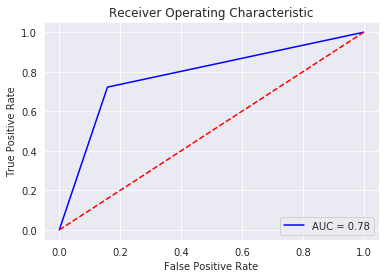

In [158]:
from sklearn import metrics

def build_roc(y_test, y_preds):
    fpr, tpr, threshold = metrics.roc_curve(y_test, y_preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.gcf().savefig('roc.png')

build_roc(y_test, XGB_preds)

In [163]:
pd.

'\npandas - a powerful data analysis and manipulation library for Python\n=====================================================================\n\n**pandas** is a Python package providing fast, flexible, and expressive data\nstructures designed to make working with "relational" or "labeled" data both\neasy and intuitive. It aims to be the fundamental high-level building block for\ndoing practical, **real world** data analysis in Python. Additionally, it has\nthe broader goal of becoming **the most powerful and flexible open source data\nanalysis / manipulation tool available in any language**. It is already well on\nits way toward this goal.\n\nMain Features\n-------------\nHere are just a few of the things that pandas does well:\n\n  - Easy handling of missing data in floating point as well as non-floating\n    point data.\n  - Size mutability: columns can be inserted and deleted from DataFrame and\n    higher dimensional objects\n  - Automatic and explicit data alignment: objects can